# Lecture 3: Feature Extraction with Python

Library used for feature extraction: [skimage](http://scikit-image.org/) 

Dataset used: [Cifar10](https://www.cs.toronto.edu/~kriz/cifar.html)

In [1]:
%matplotlib inline
from torchvision import datasets
import PIL
from skimage.feature import local_binary_pattern, greycomatrix, greycoprops
from skimage.filters import gabor
import numpy as np
import pickle
import matplotlib.pyplot as plt

Create a folder by the name 'Dataset' in the current folder and place the downlaoded [dataset](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) in it.

In [2]:
dataPath = 'Datasets/' #Path to folder containig cifar 10 dataset
#Creating torchvision datasets
trainDset = datasets.CIFAR10(dataPath, train=True) 
testDset = datasets.CIFAR10(dataPath, train=False)

In [3]:
# Size of train and test datasets
print('No. of samples in train set: '+str(len(trainDset)))
print('No. of samples in test set: '+str(len(testDset)))

No. of samples in train set: 50000
No. of samples in test set: 10000


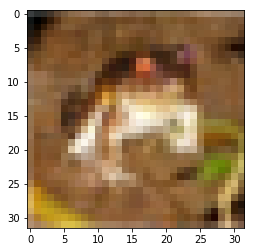

In [4]:
# Feature extraction on single image
img = trainDset[0][0] #PIL image
img_gray = img.convert('L') #Converting to grayscale
img_arr = np.array(img_gray) #Converting to array
plt.imshow(img)

### LBP

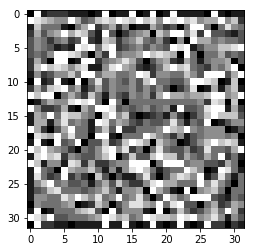

In [5]:
# Finding LBP
feat_lbp = local_binary_pattern(img_arr,8,1,'uniform') #Radius = 1, No. of neighbours = 8
feat_lbp = np.uint8((feat_lbp/feat_lbp.max())*255) #Converting to unit8
lbp_img = PIL.Image.fromarray(feat_lbp) #Conversion from array to PIL image
plt.imshow(lbp_img,cmap='gray') #Displaying LBP

In [6]:
# Energy and Entropy of LBP feature
lbp_hist,_ = np.histogram(feat_lbp,8)
lbp_hist = np.array(lbp_hist,dtype=float)
lbp_prob = np.divide(lbp_hist,np.sum(lbp_hist))
lbp_energy = np.sum(lbp_prob**2)
lbp_entropy = -np.sum(np.multiply(lbp_prob,np.log2(lbp_prob)))
print('LBP energy = '+str(lbp_energy))
print('LBP entropy = '+str(lbp_entropy))

LBP energy = 0.143215179443
LBP entropy = 2.8958499003


### Co-occurance matrix

In [7]:
# Finding GLCM features from co-occurance matrix
gCoMat = greycomatrix(img_arr, [2], [0],256,symmetric=True, normed=True) # Co-occurance matrix
contrast = greycoprops(gCoMat, prop='contrast')
dissimilarity = greycoprops(gCoMat, prop='dissimilarity')
homogeneity = greycoprops(gCoMat, prop='homogeneity')
energy = greycoprops(gCoMat, prop='energy')
correlation = greycoprops(gCoMat, prop='correlation')
print('Contrast = '+str(contrast[0][0]))
print('Dissimilarity = '+str(dissimilarity[0][0]))
print('Homogeneity = '+str(homogeneity[0][0]))
print('Energy = '+str(energy[0][0]))
print('Correlation = '+str(correlation[0][0]))

Contrast = 1296.05208333
Dissimilarity = 24.225
Homogeneity = 0.0626347751617
Energy = 0.0265676057185
Correlation = 0.612625383354


### Gabor filter

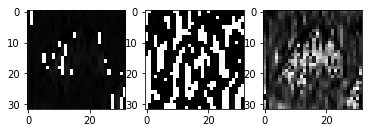

In [8]:
# Gabor filter
gaborFilt_real,gaborFilt_imag = gabor(img_arr,frequency=0.6)
gaborFilt = (gaborFilt_real**2+gaborFilt_imag**2)//2
# Displaying the filter response
fig, ax = plt.subplots(1,3)    
ax[0].imshow(gaborFilt_real,cmap='gray')
ax[1].imshow(gaborFilt_imag,cmap='gray')
ax[2].imshow(gaborFilt,cmap='gray')

In [9]:
# Energy and Entropy of Gabor filter response
gabor_hist,_ = np.histogram(gaborFilt,8)
gabor_hist = np.array(gabor_hist,dtype=float)
gabor_prob = np.divide(gabor_hist,np.sum(gabor_hist))
gabor_energy = np.sum(gabor_prob**2)
gabor_entropy = -np.sum(np.multiply(gabor_prob,np.log2(gabor_prob)))
print('Gabor energy = '+str(gabor_energy))
print('Gabor entropy = '+str(gabor_entropy))

Gabor energy = 0.246992111206
Gabor entropy = 2.35769648459


### Extracting features from all images in the dataset

In [10]:
# Generating training data by extracting features from all images
label = []
featLength = 2+5+2
trainFeats = np.zeros((len(trainDset),featLength)) #Feature vector of each image is of size 1x1030
for tr in range(len(trainDset)):
    print(str(tr+1)+'/'+str(len(trainDset)))
    img = trainDset[tr][0] #One image at a time
    img_gray = img.convert('L') #Converting to grayscale
    img_arr = np.array(img_gray.getdata()).reshape(img.size[1],img.size[0]) #Converting to array
    # LBP
    feat_lbp = local_binary_pattern(img_arr,5,2,'uniform').reshape(img.size[0]*img.size[1])
    lbp_hist,_ = np.histogram(feat_lbp,8)
    lbp_hist = np.array(lbp_hist,dtype=float)
    lbp_prob = np.divide(lbp_hist,np.sum(lbp_hist))
    lbp_energy = np.nansum(lbp_prob**2)
    lbp_entropy = -np.nansum(np.multiply(lbp_prob,np.log2(lbp_prob)))   
    # GLCM
    gCoMat = greycomatrix(img_arr, [2], [0],256,symmetric=True, normed=True)
    contrast = greycoprops(gCoMat, prop='contrast')
    dissimilarity = greycoprops(gCoMat, prop='dissimilarity')
    homogeneity = greycoprops(gCoMat, prop='homogeneity')    
    energy = greycoprops(gCoMat, prop='energy')
    correlation = greycoprops(gCoMat, prop='correlation')    
    feat_glcm = np.array([contrast[0][0],dissimilarity[0][0],homogeneity[0][0],energy[0][0],correlation[0][0]])
    # Gabor filter
    gaborFilt_real,gaborFilt_imag = gabor(img_arr,frequency=0.6)
    gaborFilt = (gaborFilt_real**2+gaborFilt_imag**2)//2
    gabor_hist,_ = np.histogram(gaborFilt,8)
    gabor_hist = np.array(gabor_hist,dtype=float)
    gabor_prob = np.divide(gabor_hist,np.sum(gabor_hist))
    gabor_energy = np.nansum(gabor_prob**2)
    gabor_entropy = -np.nansum(np.multiply(gabor_prob,np.log2(gabor_prob)))
    # Concatenating features(2+5+2)    
    concat_feat = np.concatenate(([lbp_energy,lbp_entropy],feat_glcm,[gabor_energy,gabor_entropy]),axis=0)
    trainFeats[tr,:] = concat_feat #Stacking features vectors for each image
    # Class label
    label.append(trainDset[tr][1])
trainLabel = np.array(label) #Conversion from list to array

1/50000
2/50000
3/50000
4/50000
5/50000
6/50000
7/50000
8/50000
9/50000
10/50000
11/50000
12/50000
13/50000
14/50000
15/50000
16/50000
17/50000
18/50000
19/50000
20/50000
21/50000
22/50000
23/50000
24/50000
25/50000
26/50000
27/50000
28/50000
29/50000
30/50000
31/50000
32/50000
33/50000
34/50000
35/50000
36/50000
37/50000
38/50000
39/50000
40/50000
41/50000
42/50000
43/50000
44/50000
45/50000
46/50000
47/50000
48/50000
49/50000
50/50000
51/50000
52/50000
53/50000
54/50000
55/50000
56/50000
57/50000
58/50000
59/50000
60/50000
61/50000


/home/rachana/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log2
  app.launch_new_instance()
/home/rachana/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in multiply
  app.launch_new_instance()
/home/rachana/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in log2
/home/rachana/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in multiply


62/50000
63/50000
64/50000
65/50000
66/50000
67/50000
68/50000
69/50000
70/50000
71/50000
72/50000
73/50000
74/50000
75/50000
76/50000
77/50000
78/50000
79/50000
80/50000
81/50000
82/50000
83/50000
84/50000
85/50000
86/50000
87/50000
88/50000
89/50000
90/50000
91/50000
92/50000
93/50000
94/50000
95/50000
96/50000
97/50000
98/50000
99/50000
100/50000
101/50000
102/50000
103/50000
104/50000
105/50000
106/50000
107/50000
108/50000
109/50000
110/50000
111/50000
112/50000
113/50000
114/50000
115/50000
116/50000
117/50000
118/50000
119/50000
120/50000
121/50000
122/50000
123/50000
124/50000
125/50000
126/50000
127/50000
128/50000
129/50000
130/50000
131/50000
132/50000
133/50000
134/50000
135/50000
136/50000
137/50000
138/50000
139/50000
140/50000
141/50000
142/50000
143/50000
144/50000
145/50000
146/50000
147/50000
148/50000
149/50000
150/50000
151/50000
152/50000
153/50000
154/50000
155/50000
156/50000
157/50000
158/50000
159/50000
160/50000
161/50000
162/50000
163/50000
164/50000
165/5000

902/50000
903/50000
904/50000
905/50000
906/50000
907/50000
908/50000
909/50000
910/50000
911/50000
912/50000
913/50000
914/50000
915/50000
916/50000
917/50000
918/50000
919/50000
920/50000
921/50000
922/50000
923/50000
924/50000
925/50000
926/50000
927/50000
928/50000
929/50000
930/50000
931/50000
932/50000
933/50000
934/50000
935/50000
936/50000
937/50000
938/50000
939/50000
940/50000
941/50000
942/50000
943/50000
944/50000
945/50000
946/50000
947/50000
948/50000
949/50000
950/50000
951/50000
952/50000
953/50000
954/50000
955/50000
956/50000
957/50000
958/50000
959/50000
960/50000
961/50000
962/50000
963/50000
964/50000
965/50000
966/50000
967/50000
968/50000
969/50000
970/50000
971/50000
972/50000
973/50000
974/50000
975/50000
976/50000
977/50000
978/50000
979/50000
980/50000
981/50000
982/50000
983/50000
984/50000
985/50000
986/50000
987/50000
988/50000
989/50000
990/50000
991/50000
992/50000
993/50000
994/50000
995/50000
996/50000
997/50000
998/50000
999/50000
1000/50000
1001/5000

1696/50000
1697/50000
1698/50000
1699/50000
1700/50000
1701/50000
1702/50000
1703/50000
1704/50000
1705/50000
1706/50000
1707/50000
1708/50000
1709/50000
1710/50000
1711/50000
1712/50000
1713/50000
1714/50000
1715/50000
1716/50000
1717/50000
1718/50000
1719/50000
1720/50000
1721/50000
1722/50000
1723/50000
1724/50000
1725/50000
1726/50000
1727/50000
1728/50000
1729/50000
1730/50000
1731/50000
1732/50000
1733/50000
1734/50000
1735/50000
1736/50000
1737/50000
1738/50000
1739/50000
1740/50000
1741/50000
1742/50000
1743/50000
1744/50000
1745/50000
1746/50000
1747/50000
1748/50000
1749/50000
1750/50000
1751/50000
1752/50000
1753/50000
1754/50000
1755/50000
1756/50000
1757/50000
1758/50000
1759/50000
1760/50000
1761/50000
1762/50000
1763/50000
1764/50000
1765/50000
1766/50000
1767/50000
1768/50000
1769/50000
1770/50000
1771/50000
1772/50000
1773/50000
1774/50000
1775/50000
1776/50000
1777/50000
1778/50000
1779/50000
1780/50000
1781/50000
1782/50000
1783/50000
1784/50000
1785/50000
1786/50000

2444/50000
2445/50000
2446/50000
2447/50000
2448/50000
2449/50000
2450/50000
2451/50000
2452/50000
2453/50000
2454/50000
2455/50000
2456/50000
2457/50000
2458/50000
2459/50000
2460/50000
2461/50000
2462/50000
2463/50000
2464/50000
2465/50000
2466/50000
2467/50000
2468/50000
2469/50000
2470/50000
2471/50000
2472/50000
2473/50000
2474/50000
2475/50000
2476/50000
2477/50000
2478/50000
2479/50000
2480/50000
2481/50000
2482/50000
2483/50000
2484/50000
2485/50000
2486/50000
2487/50000
2488/50000
2489/50000
2490/50000
2491/50000
2492/50000
2493/50000
2494/50000
2495/50000
2496/50000
2497/50000
2498/50000
2499/50000
2500/50000
2501/50000
2502/50000
2503/50000
2504/50000
2505/50000
2506/50000
2507/50000
2508/50000
2509/50000
2510/50000
2511/50000
2512/50000
2513/50000
2514/50000
2515/50000
2516/50000
2517/50000
2518/50000
2519/50000
2520/50000
2521/50000
2522/50000
2523/50000
2524/50000
2525/50000
2526/50000
2527/50000
2528/50000
2529/50000
2530/50000
2531/50000
2532/50000
2533/50000
2534/50000

3218/50000
3219/50000
3220/50000
3221/50000
3222/50000
3223/50000
3224/50000
3225/50000
3226/50000
3227/50000
3228/50000
3229/50000
3230/50000
3231/50000
3232/50000
3233/50000
3234/50000
3235/50000
3236/50000
3237/50000
3238/50000
3239/50000
3240/50000
3241/50000
3242/50000
3243/50000
3244/50000
3245/50000
3246/50000
3247/50000
3248/50000
3249/50000
3250/50000
3251/50000
3252/50000
3253/50000
3254/50000
3255/50000
3256/50000
3257/50000
3258/50000
3259/50000
3260/50000
3261/50000
3262/50000
3263/50000
3264/50000
3265/50000
3266/50000
3267/50000
3268/50000
3269/50000
3270/50000
3271/50000
3272/50000
3273/50000
3274/50000
3275/50000
3276/50000
3277/50000
3278/50000
3279/50000
3280/50000
3281/50000
3282/50000
3283/50000
3284/50000
3285/50000
3286/50000
3287/50000
3288/50000
3289/50000
3290/50000
3291/50000
3292/50000
3293/50000
3294/50000
3295/50000
3296/50000
3297/50000
3298/50000
3299/50000
3300/50000
3301/50000
3302/50000
3303/50000
3304/50000
3305/50000
3306/50000
3307/50000
3308/50000

3997/50000
3998/50000
3999/50000
4000/50000
4001/50000
4002/50000
4003/50000
4004/50000
4005/50000
4006/50000
4007/50000
4008/50000
4009/50000
4010/50000
4011/50000
4012/50000
4013/50000
4014/50000
4015/50000
4016/50000
4017/50000
4018/50000
4019/50000
4020/50000
4021/50000
4022/50000
4023/50000
4024/50000
4025/50000
4026/50000
4027/50000
4028/50000
4029/50000
4030/50000
4031/50000
4032/50000
4033/50000
4034/50000
4035/50000
4036/50000
4037/50000
4038/50000
4039/50000
4040/50000
4041/50000
4042/50000
4043/50000
4044/50000
4045/50000
4046/50000
4047/50000
4048/50000
4049/50000
4050/50000
4051/50000
4052/50000
4053/50000
4054/50000
4055/50000
4056/50000
4057/50000
4058/50000
4059/50000
4060/50000
4061/50000
4062/50000
4063/50000
4064/50000
4065/50000
4066/50000
4067/50000
4068/50000
4069/50000
4070/50000
4071/50000
4072/50000
4073/50000
4074/50000
4075/50000
4076/50000
4077/50000
4078/50000
4079/50000
4080/50000
4081/50000
4082/50000
4083/50000
4084/50000
4085/50000
4086/50000
4087/50000

4778/50000
4779/50000
4780/50000
4781/50000
4782/50000
4783/50000
4784/50000
4785/50000
4786/50000
4787/50000
4788/50000
4789/50000
4790/50000
4791/50000
4792/50000
4793/50000
4794/50000
4795/50000
4796/50000
4797/50000
4798/50000
4799/50000
4800/50000
4801/50000
4802/50000
4803/50000
4804/50000
4805/50000
4806/50000
4807/50000
4808/50000
4809/50000
4810/50000
4811/50000
4812/50000
4813/50000
4814/50000
4815/50000
4816/50000
4817/50000
4818/50000
4819/50000
4820/50000
4821/50000
4822/50000
4823/50000
4824/50000
4825/50000
4826/50000
4827/50000
4828/50000
4829/50000
4830/50000
4831/50000
4832/50000
4833/50000
4834/50000
4835/50000
4836/50000
4837/50000
4838/50000
4839/50000
4840/50000
4841/50000
4842/50000
4843/50000
4844/50000
4845/50000
4846/50000
4847/50000
4848/50000
4849/50000
4850/50000
4851/50000
4852/50000
4853/50000
4854/50000
4855/50000
4856/50000
4857/50000
4858/50000
4859/50000
4860/50000
4861/50000
4862/50000
4863/50000
4864/50000
4865/50000
4866/50000
4867/50000
4868/50000

5552/50000
5553/50000
5554/50000
5555/50000
5556/50000
5557/50000
5558/50000
5559/50000
5560/50000
5561/50000
5562/50000
5563/50000
5564/50000
5565/50000
5566/50000
5567/50000
5568/50000
5569/50000
5570/50000
5571/50000
5572/50000
5573/50000
5574/50000
5575/50000
5576/50000
5577/50000
5578/50000
5579/50000
5580/50000
5581/50000
5582/50000
5583/50000
5584/50000
5585/50000
5586/50000
5587/50000
5588/50000
5589/50000
5590/50000
5591/50000
5592/50000
5593/50000
5594/50000
5595/50000
5596/50000
5597/50000
5598/50000
5599/50000
5600/50000
5601/50000
5602/50000
5603/50000
5604/50000
5605/50000
5606/50000
5607/50000
5608/50000
5609/50000
5610/50000
5611/50000
5612/50000
5613/50000
5614/50000
5615/50000
5616/50000
5617/50000
5618/50000
5619/50000
5620/50000
5621/50000
5622/50000
5623/50000
5624/50000
5625/50000
5626/50000
5627/50000
5628/50000
5629/50000
5630/50000
5631/50000
5632/50000
5633/50000
5634/50000
5635/50000
5636/50000
5637/50000
5638/50000
5639/50000
5640/50000
5641/50000
5642/50000

6346/50000
6347/50000
6348/50000
6349/50000
6350/50000
6351/50000
6352/50000
6353/50000
6354/50000
6355/50000
6356/50000
6357/50000
6358/50000
6359/50000
6360/50000
6361/50000
6362/50000
6363/50000
6364/50000
6365/50000
6366/50000
6367/50000
6368/50000
6369/50000
6370/50000
6371/50000
6372/50000
6373/50000
6374/50000
6375/50000
6376/50000
6377/50000
6378/50000
6379/50000
6380/50000
6381/50000
6382/50000
6383/50000
6384/50000
6385/50000
6386/50000
6387/50000
6388/50000
6389/50000
6390/50000
6391/50000
6392/50000
6393/50000
6394/50000
6395/50000
6396/50000
6397/50000
6398/50000
6399/50000
6400/50000
6401/50000
6402/50000
6403/50000
6404/50000
6405/50000
6406/50000
6407/50000
6408/50000
6409/50000
6410/50000
6411/50000
6412/50000
6413/50000
6414/50000
6415/50000
6416/50000
6417/50000
6418/50000
6419/50000
6420/50000
6421/50000
6422/50000
6423/50000
6424/50000
6425/50000
6426/50000
6427/50000
6428/50000
6429/50000
6430/50000
6431/50000
6432/50000
6433/50000
6434/50000
6435/50000
6436/50000

7137/50000
7138/50000
7139/50000
7140/50000
7141/50000
7142/50000
7143/50000
7144/50000
7145/50000
7146/50000
7147/50000
7148/50000
7149/50000
7150/50000
7151/50000
7152/50000
7153/50000
7154/50000
7155/50000
7156/50000
7157/50000
7158/50000
7159/50000
7160/50000
7161/50000
7162/50000
7163/50000
7164/50000
7165/50000
7166/50000
7167/50000
7168/50000
7169/50000
7170/50000
7171/50000
7172/50000
7173/50000
7174/50000
7175/50000
7176/50000
7177/50000
7178/50000
7179/50000
7180/50000
7181/50000
7182/50000
7183/50000
7184/50000
7185/50000
7186/50000
7187/50000
7188/50000
7189/50000
7190/50000
7191/50000
7192/50000
7193/50000
7194/50000
7195/50000
7196/50000
7197/50000
7198/50000
7199/50000
7200/50000
7201/50000
7202/50000
7203/50000
7204/50000
7205/50000
7206/50000
7207/50000
7208/50000
7209/50000
7210/50000
7211/50000
7212/50000
7213/50000
7214/50000
7215/50000
7216/50000
7217/50000
7218/50000
7219/50000
7220/50000
7221/50000
7222/50000
7223/50000
7224/50000
7225/50000
7226/50000
7227/50000

7920/50000
7921/50000
7922/50000
7923/50000
7924/50000
7925/50000
7926/50000
7927/50000
7928/50000
7929/50000
7930/50000
7931/50000
7932/50000
7933/50000
7934/50000
7935/50000
7936/50000
7937/50000
7938/50000
7939/50000
7940/50000
7941/50000
7942/50000
7943/50000
7944/50000
7945/50000
7946/50000
7947/50000
7948/50000
7949/50000
7950/50000
7951/50000
7952/50000
7953/50000
7954/50000
7955/50000
7956/50000
7957/50000
7958/50000
7959/50000
7960/50000
7961/50000
7962/50000
7963/50000
7964/50000
7965/50000
7966/50000
7967/50000
7968/50000
7969/50000
7970/50000
7971/50000
7972/50000
7973/50000
7974/50000
7975/50000
7976/50000
7977/50000
7978/50000
7979/50000
7980/50000
7981/50000
7982/50000
7983/50000
7984/50000
7985/50000
7986/50000
7987/50000
7988/50000
7989/50000
7990/50000
7991/50000
7992/50000
7993/50000
7994/50000
7995/50000
7996/50000
7997/50000
7998/50000
7999/50000
8000/50000
8001/50000
8002/50000
8003/50000
8004/50000
8005/50000
8006/50000
8007/50000
8008/50000
8009/50000
8010/50000

8705/50000
8706/50000
8707/50000
8708/50000
8709/50000
8710/50000
8711/50000
8712/50000
8713/50000
8714/50000
8715/50000
8716/50000
8717/50000
8718/50000
8719/50000
8720/50000
8721/50000
8722/50000
8723/50000
8724/50000
8725/50000
8726/50000
8727/50000
8728/50000
8729/50000
8730/50000
8731/50000
8732/50000
8733/50000
8734/50000
8735/50000
8736/50000
8737/50000
8738/50000
8739/50000
8740/50000
8741/50000
8742/50000
8743/50000
8744/50000
8745/50000
8746/50000
8747/50000
8748/50000
8749/50000
8750/50000
8751/50000
8752/50000
8753/50000
8754/50000
8755/50000
8756/50000
8757/50000
8758/50000
8759/50000
8760/50000
8761/50000
8762/50000
8763/50000
8764/50000
8765/50000
8766/50000
8767/50000
8768/50000
8769/50000
8770/50000
8771/50000
8772/50000
8773/50000
8774/50000
8775/50000
8776/50000
8777/50000
8778/50000
8779/50000
8780/50000
8781/50000
8782/50000
8783/50000
8784/50000
8785/50000
8786/50000
8787/50000
8788/50000
8789/50000
8790/50000
8791/50000
8792/50000
8793/50000
8794/50000
8795/50000

9505/50000
9506/50000
9507/50000
9508/50000
9509/50000
9510/50000
9511/50000
9512/50000
9513/50000
9514/50000
9515/50000
9516/50000
9517/50000
9518/50000
9519/50000
9520/50000
9521/50000
9522/50000
9523/50000
9524/50000
9525/50000
9526/50000
9527/50000
9528/50000
9529/50000
9530/50000
9531/50000
9532/50000
9533/50000
9534/50000
9535/50000
9536/50000
9537/50000
9538/50000
9539/50000
9540/50000
9541/50000
9542/50000
9543/50000
9544/50000
9545/50000
9546/50000
9547/50000
9548/50000
9549/50000
9550/50000
9551/50000
9552/50000
9553/50000
9554/50000
9555/50000
9556/50000
9557/50000
9558/50000
9559/50000
9560/50000
9561/50000
9562/50000
9563/50000
9564/50000
9565/50000
9566/50000
9567/50000
9568/50000
9569/50000
9570/50000
9571/50000
9572/50000
9573/50000
9574/50000
9575/50000
9576/50000
9577/50000
9578/50000
9579/50000
9580/50000
9581/50000
9582/50000
9583/50000
9584/50000
9585/50000
9586/50000
9587/50000
9588/50000
9589/50000
9590/50000
9591/50000
9592/50000
9593/50000
9594/50000
9595/50000

10240/50000
10241/50000
10242/50000
10243/50000
10244/50000
10245/50000
10246/50000
10247/50000
10248/50000
10249/50000
10250/50000
10251/50000
10252/50000
10253/50000
10254/50000
10255/50000
10256/50000
10257/50000
10258/50000
10259/50000
10260/50000
10261/50000
10262/50000
10263/50000
10264/50000
10265/50000
10266/50000
10267/50000
10268/50000
10269/50000
10270/50000
10271/50000
10272/50000
10273/50000
10274/50000
10275/50000
10276/50000
10277/50000
10278/50000
10279/50000
10280/50000
10281/50000
10282/50000
10283/50000
10284/50000
10285/50000
10286/50000
10287/50000
10288/50000
10289/50000
10290/50000
10291/50000
10292/50000
10293/50000
10294/50000
10295/50000
10296/50000
10297/50000
10298/50000
10299/50000
10300/50000
10301/50000
10302/50000
10303/50000
10304/50000
10305/50000
10306/50000
10307/50000
10308/50000
10309/50000
10310/50000
10311/50000
10312/50000
10313/50000
10314/50000
10315/50000
10316/50000
10317/50000
10318/50000
10319/50000
10320/50000
10321/50000
10322/50000
1032

10954/50000
10955/50000
10956/50000
10957/50000
10958/50000
10959/50000
10960/50000
10961/50000
10962/50000
10963/50000
10964/50000
10965/50000
10966/50000
10967/50000
10968/50000
10969/50000
10970/50000
10971/50000
10972/50000
10973/50000
10974/50000
10975/50000
10976/50000
10977/50000
10978/50000
10979/50000
10980/50000
10981/50000
10982/50000
10983/50000
10984/50000
10985/50000
10986/50000
10987/50000
10988/50000
10989/50000
10990/50000
10991/50000
10992/50000
10993/50000
10994/50000
10995/50000
10996/50000
10997/50000
10998/50000
10999/50000
11000/50000
11001/50000
11002/50000
11003/50000
11004/50000
11005/50000
11006/50000
11007/50000
11008/50000
11009/50000
11010/50000
11011/50000
11012/50000
11013/50000
11014/50000
11015/50000
11016/50000
11017/50000
11018/50000
11019/50000
11020/50000
11021/50000
11022/50000
11023/50000
11024/50000
11025/50000
11026/50000
11027/50000
11028/50000
11029/50000
11030/50000
11031/50000
11032/50000
11033/50000
11034/50000
11035/50000
11036/50000
1103

11667/50000
11668/50000
11669/50000
11670/50000
11671/50000
11672/50000
11673/50000
11674/50000
11675/50000
11676/50000
11677/50000
11678/50000
11679/50000
11680/50000
11681/50000
11682/50000
11683/50000
11684/50000
11685/50000
11686/50000
11687/50000
11688/50000
11689/50000
11690/50000
11691/50000
11692/50000
11693/50000
11694/50000
11695/50000
11696/50000
11697/50000
11698/50000
11699/50000
11700/50000
11701/50000
11702/50000
11703/50000
11704/50000
11705/50000
11706/50000
11707/50000
11708/50000
11709/50000
11710/50000
11711/50000
11712/50000
11713/50000
11714/50000
11715/50000
11716/50000
11717/50000
11718/50000
11719/50000
11720/50000
11721/50000
11722/50000
11723/50000
11724/50000
11725/50000
11726/50000
11727/50000
11728/50000
11729/50000
11730/50000
11731/50000
11732/50000
11733/50000
11734/50000
11735/50000
11736/50000
11737/50000
11738/50000
11739/50000
11740/50000
11741/50000
11742/50000
11743/50000
11744/50000
11745/50000
11746/50000
11747/50000
11748/50000
11749/50000
1175

12384/50000
12385/50000
12386/50000
12387/50000
12388/50000
12389/50000
12390/50000
12391/50000
12392/50000
12393/50000
12394/50000
12395/50000
12396/50000
12397/50000
12398/50000
12399/50000
12400/50000
12401/50000
12402/50000
12403/50000
12404/50000
12405/50000
12406/50000
12407/50000
12408/50000
12409/50000
12410/50000
12411/50000
12412/50000
12413/50000
12414/50000
12415/50000
12416/50000
12417/50000
12418/50000
12419/50000
12420/50000
12421/50000
12422/50000
12423/50000
12424/50000
12425/50000
12426/50000
12427/50000
12428/50000
12429/50000
12430/50000
12431/50000
12432/50000
12433/50000
12434/50000
12435/50000
12436/50000
12437/50000
12438/50000
12439/50000
12440/50000
12441/50000
12442/50000
12443/50000
12444/50000
12445/50000
12446/50000
12447/50000
12448/50000
12449/50000
12450/50000
12451/50000
12452/50000
12453/50000
12454/50000
12455/50000
12456/50000
12457/50000
12458/50000
12459/50000
12460/50000
12461/50000
12462/50000
12463/50000
12464/50000
12465/50000
12466/50000
1246

13123/50000
13124/50000
13125/50000
13126/50000
13127/50000
13128/50000
13129/50000
13130/50000
13131/50000
13132/50000
13133/50000
13134/50000
13135/50000
13136/50000
13137/50000
13138/50000
13139/50000
13140/50000
13141/50000
13142/50000
13143/50000
13144/50000
13145/50000
13146/50000
13147/50000
13148/50000
13149/50000
13150/50000
13151/50000
13152/50000
13153/50000
13154/50000
13155/50000
13156/50000
13157/50000
13158/50000
13159/50000
13160/50000
13161/50000
13162/50000
13163/50000
13164/50000
13165/50000
13166/50000
13167/50000
13168/50000
13169/50000
13170/50000
13171/50000
13172/50000
13173/50000
13174/50000
13175/50000
13176/50000
13177/50000
13178/50000
13179/50000
13180/50000
13181/50000
13182/50000
13183/50000
13184/50000
13185/50000
13186/50000
13187/50000
13188/50000
13189/50000
13190/50000
13191/50000
13192/50000
13193/50000
13194/50000
13195/50000
13196/50000
13197/50000
13198/50000
13199/50000
13200/50000
13201/50000
13202/50000
13203/50000
13204/50000
13205/50000
1320

13809/50000
13810/50000
13811/50000
13812/50000
13813/50000
13814/50000
13815/50000
13816/50000
13817/50000
13818/50000
13819/50000
13820/50000
13821/50000
13822/50000
13823/50000
13824/50000
13825/50000
13826/50000
13827/50000
13828/50000
13829/50000
13830/50000
13831/50000
13832/50000
13833/50000
13834/50000
13835/50000
13836/50000
13837/50000
13838/50000
13839/50000
13840/50000
13841/50000
13842/50000
13843/50000
13844/50000
13845/50000
13846/50000
13847/50000
13848/50000
13849/50000
13850/50000
13851/50000
13852/50000
13853/50000
13854/50000
13855/50000
13856/50000
13857/50000
13858/50000
13859/50000
13860/50000
13861/50000
13862/50000
13863/50000
13864/50000
13865/50000
13866/50000
13867/50000
13868/50000
13869/50000
13870/50000
13871/50000
13872/50000
13873/50000
13874/50000
13875/50000
13876/50000
13877/50000
13878/50000
13879/50000
13880/50000
13881/50000
13882/50000
13883/50000
13884/50000
13885/50000
13886/50000
13887/50000
13888/50000
13889/50000
13890/50000
13891/50000
1389

14492/50000
14493/50000
14494/50000
14495/50000
14496/50000
14497/50000
14498/50000
14499/50000
14500/50000
14501/50000
14502/50000
14503/50000
14504/50000
14505/50000
14506/50000
14507/50000
14508/50000
14509/50000
14510/50000
14511/50000
14512/50000
14513/50000
14514/50000
14515/50000
14516/50000
14517/50000
14518/50000
14519/50000
14520/50000
14521/50000
14522/50000
14523/50000
14524/50000
14525/50000
14526/50000
14527/50000
14528/50000
14529/50000
14530/50000
14531/50000
14532/50000
14533/50000
14534/50000
14535/50000
14536/50000
14537/50000
14538/50000
14539/50000
14540/50000
14541/50000
14542/50000
14543/50000
14544/50000
14545/50000
14546/50000
14547/50000
14548/50000
14549/50000
14550/50000
14551/50000
14552/50000
14553/50000
14554/50000
14555/50000
14556/50000
14557/50000
14558/50000
14559/50000
14560/50000
14561/50000
14562/50000
14563/50000
14564/50000
14565/50000
14566/50000
14567/50000
14568/50000
14569/50000
14570/50000
14571/50000
14572/50000
14573/50000
14574/50000
1457

15182/50000
15183/50000
15184/50000
15185/50000
15186/50000
15187/50000
15188/50000
15189/50000
15190/50000
15191/50000
15192/50000
15193/50000
15194/50000
15195/50000
15196/50000
15197/50000
15198/50000
15199/50000
15200/50000
15201/50000
15202/50000
15203/50000
15204/50000
15205/50000
15206/50000
15207/50000
15208/50000
15209/50000
15210/50000
15211/50000
15212/50000
15213/50000
15214/50000
15215/50000
15216/50000
15217/50000
15218/50000
15219/50000
15220/50000
15221/50000
15222/50000
15223/50000
15224/50000
15225/50000
15226/50000
15227/50000
15228/50000
15229/50000
15230/50000
15231/50000
15232/50000
15233/50000
15234/50000
15235/50000
15236/50000
15237/50000
15238/50000
15239/50000
15240/50000
15241/50000
15242/50000
15243/50000
15244/50000
15245/50000
15246/50000
15247/50000
15248/50000
15249/50000
15250/50000
15251/50000
15252/50000
15253/50000
15254/50000
15255/50000
15256/50000
15257/50000
15258/50000
15259/50000
15260/50000
15261/50000
15262/50000
15263/50000
15264/50000
1526

15869/50000
15870/50000
15871/50000
15872/50000
15873/50000
15874/50000
15875/50000
15876/50000
15877/50000
15878/50000
15879/50000
15880/50000
15881/50000
15882/50000
15883/50000
15884/50000
15885/50000
15886/50000
15887/50000
15888/50000
15889/50000
15890/50000
15891/50000
15892/50000
15893/50000
15894/50000
15895/50000
15896/50000
15897/50000
15898/50000
15899/50000
15900/50000
15901/50000
15902/50000
15903/50000
15904/50000
15905/50000
15906/50000
15907/50000
15908/50000
15909/50000
15910/50000
15911/50000
15912/50000
15913/50000
15914/50000
15915/50000
15916/50000
15917/50000
15918/50000
15919/50000
15920/50000
15921/50000
15922/50000
15923/50000
15924/50000
15925/50000
15926/50000
15927/50000
15928/50000
15929/50000
15930/50000
15931/50000
15932/50000
15933/50000
15934/50000
15935/50000
15936/50000
15937/50000
15938/50000
15939/50000
15940/50000
15941/50000
15942/50000
15943/50000
15944/50000
15945/50000
15946/50000
15947/50000
15948/50000
15949/50000
15950/50000
15951/50000
1595

16554/50000
16555/50000
16556/50000
16557/50000
16558/50000
16559/50000
16560/50000
16561/50000
16562/50000
16563/50000
16564/50000
16565/50000
16566/50000
16567/50000
16568/50000
16569/50000
16570/50000
16571/50000
16572/50000
16573/50000
16574/50000
16575/50000
16576/50000
16577/50000
16578/50000
16579/50000
16580/50000
16581/50000
16582/50000
16583/50000
16584/50000
16585/50000
16586/50000
16587/50000
16588/50000
16589/50000
16590/50000
16591/50000
16592/50000
16593/50000
16594/50000
16595/50000
16596/50000
16597/50000
16598/50000
16599/50000
16600/50000
16601/50000
16602/50000
16603/50000
16604/50000
16605/50000
16606/50000
16607/50000
16608/50000
16609/50000
16610/50000
16611/50000
16612/50000
16613/50000
16614/50000
16615/50000
16616/50000
16617/50000
16618/50000
16619/50000
16620/50000
16621/50000
16622/50000
16623/50000
16624/50000
16625/50000
16626/50000
16627/50000
16628/50000
16629/50000
16630/50000
16631/50000
16632/50000
16633/50000
16634/50000
16635/50000
16636/50000
1663

17285/50000
17286/50000
17287/50000
17288/50000
17289/50000
17290/50000
17291/50000
17292/50000
17293/50000
17294/50000
17295/50000
17296/50000
17297/50000
17298/50000
17299/50000
17300/50000
17301/50000
17302/50000
17303/50000
17304/50000
17305/50000
17306/50000
17307/50000
17308/50000
17309/50000
17310/50000
17311/50000
17312/50000
17313/50000
17314/50000
17315/50000
17316/50000
17317/50000
17318/50000
17319/50000
17320/50000
17321/50000
17322/50000
17323/50000
17324/50000
17325/50000
17326/50000
17327/50000
17328/50000
17329/50000
17330/50000
17331/50000
17332/50000
17333/50000
17334/50000
17335/50000
17336/50000
17337/50000
17338/50000
17339/50000
17340/50000
17341/50000
17342/50000
17343/50000
17344/50000
17345/50000
17346/50000
17347/50000
17348/50000
17349/50000
17350/50000
17351/50000
17352/50000
17353/50000
17354/50000
17355/50000
17356/50000
17357/50000
17358/50000
17359/50000
17360/50000
17361/50000
17362/50000
17363/50000
17364/50000
17365/50000
17366/50000
17367/50000
1736

18010/50000
18011/50000
18012/50000
18013/50000
18014/50000
18015/50000
18016/50000
18017/50000
18018/50000
18019/50000
18020/50000
18021/50000
18022/50000
18023/50000
18024/50000
18025/50000
18026/50000
18027/50000
18028/50000
18029/50000
18030/50000
18031/50000
18032/50000
18033/50000
18034/50000
18035/50000
18036/50000
18037/50000
18038/50000
18039/50000
18040/50000
18041/50000
18042/50000
18043/50000
18044/50000
18045/50000
18046/50000
18047/50000
18048/50000
18049/50000
18050/50000
18051/50000
18052/50000
18053/50000
18054/50000
18055/50000
18056/50000
18057/50000
18058/50000
18059/50000
18060/50000
18061/50000
18062/50000
18063/50000
18064/50000
18065/50000
18066/50000
18067/50000
18068/50000
18069/50000
18070/50000
18071/50000
18072/50000
18073/50000
18074/50000
18075/50000
18076/50000
18077/50000
18078/50000
18079/50000
18080/50000
18081/50000
18082/50000
18083/50000
18084/50000
18085/50000
18086/50000
18087/50000
18088/50000
18089/50000
18090/50000
18091/50000
18092/50000
1809

18698/50000
18699/50000
18700/50000
18701/50000
18702/50000
18703/50000
18704/50000
18705/50000
18706/50000
18707/50000
18708/50000
18709/50000
18710/50000
18711/50000
18712/50000
18713/50000
18714/50000
18715/50000
18716/50000
18717/50000
18718/50000
18719/50000
18720/50000
18721/50000
18722/50000
18723/50000
18724/50000
18725/50000
18726/50000
18727/50000
18728/50000
18729/50000
18730/50000
18731/50000
18732/50000
18733/50000
18734/50000
18735/50000
18736/50000
18737/50000
18738/50000
18739/50000
18740/50000
18741/50000
18742/50000
18743/50000
18744/50000
18745/50000
18746/50000
18747/50000
18748/50000
18749/50000
18750/50000
18751/50000
18752/50000
18753/50000
18754/50000
18755/50000
18756/50000
18757/50000
18758/50000
18759/50000
18760/50000
18761/50000
18762/50000
18763/50000
18764/50000
18765/50000
18766/50000
18767/50000
18768/50000
18769/50000
18770/50000
18771/50000
18772/50000
18773/50000
18774/50000
18775/50000
18776/50000
18777/50000
18778/50000
18779/50000
18780/50000
1878

19385/50000
19386/50000
19387/50000
19388/50000
19389/50000
19390/50000
19391/50000
19392/50000
19393/50000
19394/50000
19395/50000
19396/50000
19397/50000
19398/50000
19399/50000
19400/50000
19401/50000
19402/50000
19403/50000
19404/50000
19405/50000
19406/50000
19407/50000
19408/50000
19409/50000
19410/50000
19411/50000
19412/50000
19413/50000
19414/50000
19415/50000
19416/50000
19417/50000
19418/50000
19419/50000
19420/50000
19421/50000
19422/50000
19423/50000
19424/50000
19425/50000
19426/50000
19427/50000
19428/50000
19429/50000
19430/50000
19431/50000
19432/50000
19433/50000
19434/50000
19435/50000
19436/50000
19437/50000
19438/50000
19439/50000
19440/50000
19441/50000
19442/50000
19443/50000
19444/50000
19445/50000
19446/50000
19447/50000
19448/50000
19449/50000
19450/50000
19451/50000
19452/50000
19453/50000
19454/50000
19455/50000
19456/50000
19457/50000
19458/50000
19459/50000
19460/50000
19461/50000
19462/50000
19463/50000
19464/50000
19465/50000
19466/50000
19467/50000
1946

20076/50000
20077/50000
20078/50000
20079/50000
20080/50000
20081/50000
20082/50000
20083/50000
20084/50000
20085/50000
20086/50000
20087/50000
20088/50000
20089/50000
20090/50000
20091/50000
20092/50000
20093/50000
20094/50000
20095/50000
20096/50000
20097/50000
20098/50000
20099/50000
20100/50000
20101/50000
20102/50000
20103/50000
20104/50000
20105/50000
20106/50000
20107/50000
20108/50000
20109/50000
20110/50000
20111/50000
20112/50000
20113/50000
20114/50000
20115/50000
20116/50000
20117/50000
20118/50000
20119/50000
20120/50000
20121/50000
20122/50000
20123/50000
20124/50000
20125/50000
20126/50000
20127/50000
20128/50000
20129/50000
20130/50000
20131/50000
20132/50000
20133/50000
20134/50000
20135/50000
20136/50000
20137/50000
20138/50000
20139/50000
20140/50000
20141/50000
20142/50000
20143/50000
20144/50000
20145/50000
20146/50000
20147/50000
20148/50000
20149/50000
20150/50000
20151/50000
20152/50000
20153/50000
20154/50000
20155/50000
20156/50000
20157/50000
20158/50000
2015

20759/50000
20760/50000
20761/50000
20762/50000
20763/50000
20764/50000
20765/50000
20766/50000
20767/50000
20768/50000
20769/50000
20770/50000
20771/50000
20772/50000
20773/50000
20774/50000
20775/50000
20776/50000
20777/50000
20778/50000
20779/50000
20780/50000
20781/50000
20782/50000
20783/50000
20784/50000
20785/50000
20786/50000
20787/50000
20788/50000
20789/50000
20790/50000
20791/50000
20792/50000
20793/50000
20794/50000
20795/50000
20796/50000
20797/50000
20798/50000
20799/50000
20800/50000
20801/50000
20802/50000
20803/50000
20804/50000
20805/50000
20806/50000
20807/50000
20808/50000
20809/50000
20810/50000
20811/50000
20812/50000
20813/50000
20814/50000
20815/50000
20816/50000
20817/50000
20818/50000
20819/50000
20820/50000
20821/50000
20822/50000
20823/50000
20824/50000
20825/50000
20826/50000
20827/50000
20828/50000
20829/50000
20830/50000
20831/50000
20832/50000
20833/50000
20834/50000
20835/50000
20836/50000
20837/50000
20838/50000
20839/50000
20840/50000
20841/50000
2084

21443/50000
21444/50000
21445/50000
21446/50000
21447/50000
21448/50000
21449/50000
21450/50000
21451/50000
21452/50000
21453/50000
21454/50000
21455/50000
21456/50000
21457/50000
21458/50000
21459/50000
21460/50000
21461/50000
21462/50000
21463/50000
21464/50000
21465/50000
21466/50000
21467/50000
21468/50000
21469/50000
21470/50000
21471/50000
21472/50000
21473/50000
21474/50000
21475/50000
21476/50000
21477/50000
21478/50000
21479/50000
21480/50000
21481/50000
21482/50000
21483/50000
21484/50000
21485/50000
21486/50000
21487/50000
21488/50000
21489/50000
21490/50000
21491/50000
21492/50000
21493/50000
21494/50000
21495/50000
21496/50000
21497/50000
21498/50000
21499/50000
21500/50000
21501/50000
21502/50000
21503/50000
21504/50000
21505/50000
21506/50000
21507/50000
21508/50000
21509/50000
21510/50000
21511/50000
21512/50000
21513/50000
21514/50000
21515/50000
21516/50000
21517/50000
21518/50000
21519/50000
21520/50000
21521/50000
21522/50000
21523/50000
21524/50000
21525/50000
2152

22181/50000
22182/50000
22183/50000
22184/50000
22185/50000
22186/50000
22187/50000
22188/50000
22189/50000
22190/50000
22191/50000
22192/50000
22193/50000
22194/50000
22195/50000
22196/50000
22197/50000
22198/50000
22199/50000
22200/50000
22201/50000
22202/50000
22203/50000
22204/50000
22205/50000
22206/50000
22207/50000
22208/50000
22209/50000
22210/50000
22211/50000
22212/50000
22213/50000
22214/50000
22215/50000
22216/50000
22217/50000
22218/50000
22219/50000
22220/50000
22221/50000
22222/50000
22223/50000
22224/50000
22225/50000
22226/50000
22227/50000
22228/50000
22229/50000
22230/50000
22231/50000
22232/50000
22233/50000
22234/50000
22235/50000
22236/50000
22237/50000
22238/50000
22239/50000
22240/50000
22241/50000
22242/50000
22243/50000
22244/50000
22245/50000
22246/50000
22247/50000
22248/50000
22249/50000
22250/50000
22251/50000
22252/50000
22253/50000
22254/50000
22255/50000
22256/50000
22257/50000
22258/50000
22259/50000
22260/50000
22261/50000
22262/50000
22263/50000
2226

22891/50000
22892/50000
22893/50000
22894/50000
22895/50000
22896/50000
22897/50000
22898/50000
22899/50000
22900/50000
22901/50000
22902/50000
22903/50000
22904/50000
22905/50000
22906/50000
22907/50000
22908/50000
22909/50000
22910/50000
22911/50000
22912/50000
22913/50000
22914/50000
22915/50000
22916/50000
22917/50000
22918/50000
22919/50000
22920/50000
22921/50000
22922/50000
22923/50000
22924/50000
22925/50000
22926/50000
22927/50000
22928/50000
22929/50000
22930/50000
22931/50000
22932/50000
22933/50000
22934/50000
22935/50000
22936/50000
22937/50000
22938/50000
22939/50000
22940/50000
22941/50000
22942/50000
22943/50000
22944/50000
22945/50000
22946/50000
22947/50000
22948/50000
22949/50000
22950/50000
22951/50000
22952/50000
22953/50000
22954/50000
22955/50000
22956/50000
22957/50000
22958/50000
22959/50000
22960/50000
22961/50000
22962/50000
22963/50000
22964/50000
22965/50000
22966/50000
22967/50000
22968/50000
22969/50000
22970/50000
22971/50000
22972/50000
22973/50000
2297

23630/50000
23631/50000
23632/50000
23633/50000
23634/50000
23635/50000
23636/50000
23637/50000
23638/50000
23639/50000
23640/50000
23641/50000
23642/50000
23643/50000
23644/50000
23645/50000
23646/50000
23647/50000
23648/50000
23649/50000
23650/50000
23651/50000
23652/50000
23653/50000
23654/50000
23655/50000
23656/50000
23657/50000
23658/50000
23659/50000
23660/50000
23661/50000
23662/50000
23663/50000
23664/50000
23665/50000
23666/50000
23667/50000
23668/50000
23669/50000
23670/50000
23671/50000
23672/50000
23673/50000
23674/50000
23675/50000
23676/50000
23677/50000
23678/50000
23679/50000
23680/50000
23681/50000
23682/50000
23683/50000
23684/50000
23685/50000
23686/50000
23687/50000
23688/50000
23689/50000
23690/50000
23691/50000
23692/50000
23693/50000
23694/50000
23695/50000
23696/50000
23697/50000
23698/50000
23699/50000
23700/50000
23701/50000
23702/50000
23703/50000
23704/50000
23705/50000
23706/50000
23707/50000
23708/50000
23709/50000
23710/50000
23711/50000
23712/50000
2371

24363/50000
24364/50000
24365/50000
24366/50000
24367/50000
24368/50000
24369/50000
24370/50000
24371/50000
24372/50000
24373/50000
24374/50000
24375/50000
24376/50000
24377/50000
24378/50000
24379/50000
24380/50000
24381/50000
24382/50000
24383/50000
24384/50000
24385/50000
24386/50000
24387/50000
24388/50000
24389/50000
24390/50000
24391/50000
24392/50000
24393/50000
24394/50000
24395/50000
24396/50000
24397/50000
24398/50000
24399/50000
24400/50000
24401/50000
24402/50000
24403/50000
24404/50000
24405/50000
24406/50000
24407/50000
24408/50000
24409/50000
24410/50000
24411/50000
24412/50000
24413/50000
24414/50000
24415/50000
24416/50000
24417/50000
24418/50000
24419/50000
24420/50000
24421/50000
24422/50000
24423/50000
24424/50000
24425/50000
24426/50000
24427/50000
24428/50000
24429/50000
24430/50000
24431/50000
24432/50000
24433/50000
24434/50000
24435/50000
24436/50000
24437/50000
24438/50000
24439/50000
24440/50000
24441/50000
24442/50000
24443/50000
24444/50000
24445/50000
2444

25104/50000
25105/50000
25106/50000
25107/50000
25108/50000
25109/50000
25110/50000
25111/50000
25112/50000
25113/50000
25114/50000
25115/50000
25116/50000
25117/50000
25118/50000
25119/50000
25120/50000
25121/50000
25122/50000
25123/50000
25124/50000
25125/50000
25126/50000
25127/50000
25128/50000
25129/50000
25130/50000
25131/50000
25132/50000
25133/50000
25134/50000
25135/50000
25136/50000
25137/50000
25138/50000
25139/50000
25140/50000
25141/50000
25142/50000
25143/50000
25144/50000
25145/50000
25146/50000
25147/50000
25148/50000
25149/50000
25150/50000
25151/50000
25152/50000
25153/50000
25154/50000
25155/50000
25156/50000
25157/50000
25158/50000
25159/50000
25160/50000
25161/50000
25162/50000
25163/50000
25164/50000
25165/50000
25166/50000
25167/50000
25168/50000
25169/50000
25170/50000
25171/50000
25172/50000
25173/50000
25174/50000
25175/50000
25176/50000
25177/50000
25178/50000
25179/50000
25180/50000
25181/50000
25182/50000
25183/50000
25184/50000
25185/50000
25186/50000
2518

25826/50000
25827/50000
25828/50000
25829/50000
25830/50000
25831/50000
25832/50000
25833/50000
25834/50000
25835/50000
25836/50000
25837/50000
25838/50000
25839/50000
25840/50000
25841/50000
25842/50000
25843/50000
25844/50000
25845/50000
25846/50000
25847/50000
25848/50000
25849/50000
25850/50000
25851/50000
25852/50000
25853/50000
25854/50000
25855/50000
25856/50000
25857/50000
25858/50000
25859/50000
25860/50000
25861/50000
25862/50000
25863/50000
25864/50000
25865/50000
25866/50000
25867/50000
25868/50000
25869/50000
25870/50000
25871/50000
25872/50000
25873/50000
25874/50000
25875/50000
25876/50000
25877/50000
25878/50000
25879/50000
25880/50000
25881/50000
25882/50000
25883/50000
25884/50000
25885/50000
25886/50000
25887/50000
25888/50000
25889/50000
25890/50000
25891/50000
25892/50000
25893/50000
25894/50000
25895/50000
25896/50000
25897/50000
25898/50000
25899/50000
25900/50000
25901/50000
25902/50000
25903/50000
25904/50000
25905/50000
25906/50000
25907/50000
25908/50000
2590

26550/50000
26551/50000
26552/50000
26553/50000
26554/50000
26555/50000
26556/50000
26557/50000
26558/50000
26559/50000
26560/50000
26561/50000
26562/50000
26563/50000
26564/50000
26565/50000
26566/50000
26567/50000
26568/50000
26569/50000
26570/50000
26571/50000
26572/50000
26573/50000
26574/50000
26575/50000
26576/50000
26577/50000
26578/50000
26579/50000
26580/50000
26581/50000
26582/50000
26583/50000
26584/50000
26585/50000
26586/50000
26587/50000
26588/50000
26589/50000
26590/50000
26591/50000
26592/50000
26593/50000
26594/50000
26595/50000
26596/50000
26597/50000
26598/50000
26599/50000
26600/50000
26601/50000
26602/50000
26603/50000
26604/50000
26605/50000
26606/50000
26607/50000
26608/50000
26609/50000
26610/50000
26611/50000
26612/50000
26613/50000
26614/50000
26615/50000
26616/50000
26617/50000
26618/50000
26619/50000
26620/50000
26621/50000
26622/50000
26623/50000
26624/50000
26625/50000
26626/50000
26627/50000
26628/50000
26629/50000
26630/50000
26631/50000
26632/50000
2663

27233/50000
27234/50000
27235/50000
27236/50000
27237/50000
27238/50000
27239/50000
27240/50000
27241/50000
27242/50000
27243/50000
27244/50000
27245/50000
27246/50000
27247/50000
27248/50000
27249/50000
27250/50000
27251/50000
27252/50000
27253/50000
27254/50000
27255/50000
27256/50000
27257/50000
27258/50000
27259/50000
27260/50000
27261/50000
27262/50000
27263/50000
27264/50000
27265/50000
27266/50000
27267/50000
27268/50000
27269/50000
27270/50000
27271/50000
27272/50000
27273/50000
27274/50000
27275/50000
27276/50000
27277/50000
27278/50000
27279/50000
27280/50000
27281/50000
27282/50000
27283/50000
27284/50000
27285/50000
27286/50000
27287/50000
27288/50000
27289/50000
27290/50000
27291/50000
27292/50000
27293/50000
27294/50000
27295/50000
27296/50000
27297/50000
27298/50000
27299/50000
27300/50000
27301/50000
27302/50000
27303/50000
27304/50000
27305/50000
27306/50000
27307/50000
27308/50000
27309/50000
27310/50000
27311/50000
27312/50000
27313/50000
27314/50000
27315/50000
2731

27918/50000
27919/50000
27920/50000
27921/50000
27922/50000
27923/50000
27924/50000
27925/50000
27926/50000
27927/50000
27928/50000
27929/50000
27930/50000
27931/50000
27932/50000
27933/50000
27934/50000
27935/50000
27936/50000
27937/50000
27938/50000
27939/50000
27940/50000
27941/50000
27942/50000
27943/50000
27944/50000
27945/50000
27946/50000
27947/50000
27948/50000
27949/50000
27950/50000
27951/50000
27952/50000
27953/50000
27954/50000
27955/50000
27956/50000
27957/50000
27958/50000
27959/50000
27960/50000
27961/50000
27962/50000
27963/50000
27964/50000
27965/50000
27966/50000
27967/50000
27968/50000
27969/50000
27970/50000
27971/50000
27972/50000
27973/50000
27974/50000
27975/50000
27976/50000
27977/50000
27978/50000
27979/50000
27980/50000
27981/50000
27982/50000
27983/50000
27984/50000
27985/50000
27986/50000
27987/50000
27988/50000
27989/50000
27990/50000
27991/50000
27992/50000
27993/50000
27994/50000
27995/50000
27996/50000
27997/50000
27998/50000
27999/50000
28000/50000
2800

28603/50000
28604/50000
28605/50000
28606/50000
28607/50000
28608/50000
28609/50000
28610/50000
28611/50000
28612/50000
28613/50000
28614/50000
28615/50000
28616/50000
28617/50000
28618/50000
28619/50000
28620/50000
28621/50000
28622/50000
28623/50000
28624/50000
28625/50000
28626/50000
28627/50000
28628/50000
28629/50000
28630/50000
28631/50000
28632/50000
28633/50000
28634/50000
28635/50000
28636/50000
28637/50000
28638/50000
28639/50000
28640/50000
28641/50000
28642/50000
28643/50000
28644/50000
28645/50000
28646/50000
28647/50000
28648/50000
28649/50000
28650/50000
28651/50000
28652/50000
28653/50000
28654/50000
28655/50000
28656/50000
28657/50000
28658/50000
28659/50000
28660/50000
28661/50000
28662/50000
28663/50000
28664/50000
28665/50000
28666/50000
28667/50000
28668/50000
28669/50000
28670/50000
28671/50000
28672/50000
28673/50000
28674/50000
28675/50000
28676/50000
28677/50000
28678/50000
28679/50000
28680/50000
28681/50000
28682/50000
28683/50000
28684/50000
28685/50000
2868

29345/50000
29346/50000
29347/50000
29348/50000
29349/50000
29350/50000
29351/50000
29352/50000
29353/50000
29354/50000
29355/50000
29356/50000
29357/50000
29358/50000
29359/50000
29360/50000
29361/50000
29362/50000
29363/50000
29364/50000
29365/50000
29366/50000
29367/50000
29368/50000
29369/50000
29370/50000
29371/50000
29372/50000
29373/50000
29374/50000
29375/50000
29376/50000
29377/50000
29378/50000
29379/50000
29380/50000
29381/50000
29382/50000
29383/50000
29384/50000
29385/50000
29386/50000
29387/50000
29388/50000
29389/50000
29390/50000
29391/50000
29392/50000
29393/50000
29394/50000
29395/50000
29396/50000
29397/50000
29398/50000
29399/50000
29400/50000
29401/50000
29402/50000
29403/50000
29404/50000
29405/50000
29406/50000
29407/50000
29408/50000
29409/50000
29410/50000
29411/50000
29412/50000
29413/50000
29414/50000
29415/50000
29416/50000
29417/50000
29418/50000
29419/50000
29420/50000
29421/50000
29422/50000
29423/50000
29424/50000
29425/50000
29426/50000
29427/50000
2942

30028/50000
30029/50000
30030/50000
30031/50000
30032/50000
30033/50000
30034/50000
30035/50000
30036/50000
30037/50000
30038/50000
30039/50000
30040/50000
30041/50000
30042/50000
30043/50000
30044/50000
30045/50000
30046/50000
30047/50000
30048/50000
30049/50000
30050/50000
30051/50000
30052/50000
30053/50000
30054/50000
30055/50000
30056/50000
30057/50000
30058/50000
30059/50000
30060/50000
30061/50000
30062/50000
30063/50000
30064/50000
30065/50000
30066/50000
30067/50000
30068/50000
30069/50000
30070/50000
30071/50000
30072/50000
30073/50000
30074/50000
30075/50000
30076/50000
30077/50000
30078/50000
30079/50000
30080/50000
30081/50000
30082/50000
30083/50000
30084/50000
30085/50000
30086/50000
30087/50000
30088/50000
30089/50000
30090/50000
30091/50000
30092/50000
30093/50000
30094/50000
30095/50000
30096/50000
30097/50000
30098/50000
30099/50000
30100/50000
30101/50000
30102/50000
30103/50000
30104/50000
30105/50000
30106/50000
30107/50000
30108/50000
30109/50000
30110/50000
3011

30712/50000
30713/50000
30714/50000
30715/50000
30716/50000
30717/50000
30718/50000
30719/50000
30720/50000
30721/50000
30722/50000
30723/50000
30724/50000
30725/50000
30726/50000
30727/50000
30728/50000
30729/50000
30730/50000
30731/50000
30732/50000
30733/50000
30734/50000
30735/50000
30736/50000
30737/50000
30738/50000
30739/50000
30740/50000
30741/50000
30742/50000
30743/50000
30744/50000
30745/50000
30746/50000
30747/50000
30748/50000
30749/50000
30750/50000
30751/50000
30752/50000
30753/50000
30754/50000
30755/50000
30756/50000
30757/50000
30758/50000
30759/50000
30760/50000
30761/50000
30762/50000
30763/50000
30764/50000
30765/50000
30766/50000
30767/50000
30768/50000
30769/50000
30770/50000
30771/50000
30772/50000
30773/50000
30774/50000
30775/50000
30776/50000
30777/50000
30778/50000
30779/50000
30780/50000
30781/50000
30782/50000
30783/50000
30784/50000
30785/50000
30786/50000
30787/50000
30788/50000
30789/50000
30790/50000
30791/50000
30792/50000
30793/50000
30794/50000
3079

31456/50000
31457/50000
31458/50000
31459/50000
31460/50000
31461/50000
31462/50000
31463/50000
31464/50000
31465/50000
31466/50000
31467/50000
31468/50000
31469/50000
31470/50000
31471/50000
31472/50000
31473/50000
31474/50000
31475/50000
31476/50000
31477/50000
31478/50000
31479/50000
31480/50000
31481/50000
31482/50000
31483/50000
31484/50000
31485/50000
31486/50000
31487/50000
31488/50000
31489/50000
31490/50000
31491/50000
31492/50000
31493/50000
31494/50000
31495/50000
31496/50000
31497/50000
31498/50000
31499/50000
31500/50000
31501/50000
31502/50000
31503/50000
31504/50000
31505/50000
31506/50000
31507/50000
31508/50000
31509/50000
31510/50000
31511/50000
31512/50000
31513/50000
31514/50000
31515/50000
31516/50000
31517/50000
31518/50000
31519/50000
31520/50000
31521/50000
31522/50000
31523/50000
31524/50000
31525/50000
31526/50000
31527/50000
31528/50000
31529/50000
31530/50000
31531/50000
31532/50000
31533/50000
31534/50000
31535/50000
31536/50000
31537/50000
31538/50000
3153

32139/50000
32140/50000
32141/50000
32142/50000
32143/50000
32144/50000
32145/50000
32146/50000
32147/50000
32148/50000
32149/50000
32150/50000
32151/50000
32152/50000
32153/50000
32154/50000
32155/50000
32156/50000
32157/50000
32158/50000
32159/50000
32160/50000
32161/50000
32162/50000
32163/50000
32164/50000
32165/50000
32166/50000
32167/50000
32168/50000
32169/50000
32170/50000
32171/50000
32172/50000
32173/50000
32174/50000
32175/50000
32176/50000
32177/50000
32178/50000
32179/50000
32180/50000
32181/50000
32182/50000
32183/50000
32184/50000
32185/50000
32186/50000
32187/50000
32188/50000
32189/50000
32190/50000
32191/50000
32192/50000
32193/50000
32194/50000
32195/50000
32196/50000
32197/50000
32198/50000
32199/50000
32200/50000
32201/50000
32202/50000
32203/50000
32204/50000
32205/50000
32206/50000
32207/50000
32208/50000
32209/50000
32210/50000
32211/50000
32212/50000
32213/50000
32214/50000
32215/50000
32216/50000
32217/50000
32218/50000
32219/50000
32220/50000
32221/50000
3222

32826/50000
32827/50000
32828/50000
32829/50000
32830/50000
32831/50000
32832/50000
32833/50000
32834/50000
32835/50000
32836/50000
32837/50000
32838/50000
32839/50000
32840/50000
32841/50000
32842/50000
32843/50000
32844/50000
32845/50000
32846/50000
32847/50000
32848/50000
32849/50000
32850/50000
32851/50000
32852/50000
32853/50000
32854/50000
32855/50000
32856/50000
32857/50000
32858/50000
32859/50000
32860/50000
32861/50000
32862/50000
32863/50000
32864/50000
32865/50000
32866/50000
32867/50000
32868/50000
32869/50000
32870/50000
32871/50000
32872/50000
32873/50000
32874/50000
32875/50000
32876/50000
32877/50000
32878/50000
32879/50000
32880/50000
32881/50000
32882/50000
32883/50000
32884/50000
32885/50000
32886/50000
32887/50000
32888/50000
32889/50000
32890/50000
32891/50000
32892/50000
32893/50000
32894/50000
32895/50000
32896/50000
32897/50000
32898/50000
32899/50000
32900/50000
32901/50000
32902/50000
32903/50000
32904/50000
32905/50000
32906/50000
32907/50000
32908/50000
3290

33512/50000
33513/50000
33514/50000
33515/50000
33516/50000
33517/50000
33518/50000
33519/50000
33520/50000
33521/50000
33522/50000
33523/50000
33524/50000
33525/50000
33526/50000
33527/50000
33528/50000
33529/50000
33530/50000
33531/50000
33532/50000
33533/50000
33534/50000
33535/50000
33536/50000
33537/50000
33538/50000
33539/50000
33540/50000
33541/50000
33542/50000
33543/50000
33544/50000
33545/50000
33546/50000
33547/50000
33548/50000
33549/50000
33550/50000
33551/50000
33552/50000
33553/50000
33554/50000
33555/50000
33556/50000
33557/50000
33558/50000
33559/50000
33560/50000
33561/50000
33562/50000
33563/50000
33564/50000
33565/50000
33566/50000
33567/50000
33568/50000
33569/50000
33570/50000
33571/50000
33572/50000
33573/50000
33574/50000
33575/50000
33576/50000
33577/50000
33578/50000
33579/50000
33580/50000
33581/50000
33582/50000
33583/50000
33584/50000
33585/50000
33586/50000
33587/50000
33588/50000
33589/50000
33590/50000
33591/50000
33592/50000
33593/50000
33594/50000
3359

34200/50000
34201/50000
34202/50000
34203/50000
34204/50000
34205/50000
34206/50000
34207/50000
34208/50000
34209/50000
34210/50000
34211/50000
34212/50000
34213/50000
34214/50000
34215/50000
34216/50000
34217/50000
34218/50000
34219/50000
34220/50000
34221/50000
34222/50000
34223/50000
34224/50000
34225/50000
34226/50000
34227/50000
34228/50000
34229/50000
34230/50000
34231/50000
34232/50000
34233/50000
34234/50000
34235/50000
34236/50000
34237/50000
34238/50000
34239/50000
34240/50000
34241/50000
34242/50000
34243/50000
34244/50000
34245/50000
34246/50000
34247/50000
34248/50000
34249/50000
34250/50000
34251/50000
34252/50000
34253/50000
34254/50000
34255/50000
34256/50000
34257/50000
34258/50000
34259/50000
34260/50000
34261/50000
34262/50000
34263/50000
34264/50000
34265/50000
34266/50000
34267/50000
34268/50000
34269/50000
34270/50000
34271/50000
34272/50000
34273/50000
34274/50000
34275/50000
34276/50000
34277/50000
34278/50000
34279/50000
34280/50000
34281/50000
34282/50000
3428

34886/50000
34887/50000
34888/50000
34889/50000
34890/50000
34891/50000
34892/50000
34893/50000
34894/50000
34895/50000
34896/50000
34897/50000
34898/50000
34899/50000
34900/50000
34901/50000
34902/50000
34903/50000
34904/50000
34905/50000
34906/50000
34907/50000
34908/50000
34909/50000
34910/50000
34911/50000
34912/50000
34913/50000
34914/50000
34915/50000
34916/50000
34917/50000
34918/50000
34919/50000
34920/50000
34921/50000
34922/50000
34923/50000
34924/50000
34925/50000
34926/50000
34927/50000
34928/50000
34929/50000
34930/50000
34931/50000
34932/50000
34933/50000
34934/50000
34935/50000
34936/50000
34937/50000
34938/50000
34939/50000
34940/50000
34941/50000
34942/50000
34943/50000
34944/50000
34945/50000
34946/50000
34947/50000
34948/50000
34949/50000
34950/50000
34951/50000
34952/50000
34953/50000
34954/50000
34955/50000
34956/50000
34957/50000
34958/50000
34959/50000
34960/50000
34961/50000
34962/50000
34963/50000
34964/50000
34965/50000
34966/50000
34967/50000
34968/50000
3496

35573/50000
35574/50000
35575/50000
35576/50000
35577/50000
35578/50000
35579/50000
35580/50000
35581/50000
35582/50000
35583/50000
35584/50000
35585/50000
35586/50000
35587/50000
35588/50000
35589/50000
35590/50000
35591/50000
35592/50000
35593/50000
35594/50000
35595/50000
35596/50000
35597/50000
35598/50000
35599/50000
35600/50000
35601/50000
35602/50000
35603/50000
35604/50000
35605/50000
35606/50000
35607/50000
35608/50000
35609/50000
35610/50000
35611/50000
35612/50000
35613/50000
35614/50000
35615/50000
35616/50000
35617/50000
35618/50000
35619/50000
35620/50000
35621/50000
35622/50000
35623/50000
35624/50000
35625/50000
35626/50000
35627/50000
35628/50000
35629/50000
35630/50000
35631/50000
35632/50000
35633/50000
35634/50000
35635/50000
35636/50000
35637/50000
35638/50000
35639/50000
35640/50000
35641/50000
35642/50000
35643/50000
35644/50000
35645/50000
35646/50000
35647/50000
35648/50000
35649/50000
35650/50000
35651/50000
35652/50000
35653/50000
35654/50000
35655/50000
3565

36260/50000
36261/50000
36262/50000
36263/50000
36264/50000
36265/50000
36266/50000
36267/50000
36268/50000
36269/50000
36270/50000
36271/50000
36272/50000
36273/50000
36274/50000
36275/50000
36276/50000
36277/50000
36278/50000
36279/50000
36280/50000
36281/50000
36282/50000
36283/50000
36284/50000
36285/50000
36286/50000
36287/50000
36288/50000
36289/50000
36290/50000
36291/50000
36292/50000
36293/50000
36294/50000
36295/50000
36296/50000
36297/50000
36298/50000
36299/50000
36300/50000
36301/50000
36302/50000
36303/50000
36304/50000
36305/50000
36306/50000
36307/50000
36308/50000
36309/50000
36310/50000
36311/50000
36312/50000
36313/50000
36314/50000
36315/50000
36316/50000
36317/50000
36318/50000
36319/50000
36320/50000
36321/50000
36322/50000
36323/50000
36324/50000
36325/50000
36326/50000
36327/50000
36328/50000
36329/50000
36330/50000
36331/50000
36332/50000
36333/50000
36334/50000
36335/50000
36336/50000
36337/50000
36338/50000
36339/50000
36340/50000
36341/50000
36342/50000
3634

36945/50000
36946/50000
36947/50000
36948/50000
36949/50000
36950/50000
36951/50000
36952/50000
36953/50000
36954/50000
36955/50000
36956/50000
36957/50000
36958/50000
36959/50000
36960/50000
36961/50000
36962/50000
36963/50000
36964/50000
36965/50000
36966/50000
36967/50000
36968/50000
36969/50000
36970/50000
36971/50000
36972/50000
36973/50000
36974/50000
36975/50000
36976/50000
36977/50000
36978/50000
36979/50000
36980/50000
36981/50000
36982/50000
36983/50000
36984/50000
36985/50000
36986/50000
36987/50000
36988/50000
36989/50000
36990/50000
36991/50000
36992/50000
36993/50000
36994/50000
36995/50000
36996/50000
36997/50000
36998/50000
36999/50000
37000/50000
37001/50000
37002/50000
37003/50000
37004/50000
37005/50000
37006/50000
37007/50000
37008/50000
37009/50000
37010/50000
37011/50000
37012/50000
37013/50000
37014/50000
37015/50000
37016/50000
37017/50000
37018/50000
37019/50000
37020/50000
37021/50000
37022/50000
37023/50000
37024/50000
37025/50000
37026/50000
37027/50000
3702

37632/50000
37633/50000
37634/50000
37635/50000
37636/50000
37637/50000
37638/50000
37639/50000
37640/50000
37641/50000
37642/50000
37643/50000
37644/50000
37645/50000
37646/50000
37647/50000
37648/50000
37649/50000
37650/50000
37651/50000
37652/50000
37653/50000
37654/50000
37655/50000
37656/50000
37657/50000
37658/50000
37659/50000
37660/50000
37661/50000
37662/50000
37663/50000
37664/50000
37665/50000
37666/50000
37667/50000
37668/50000
37669/50000
37670/50000
37671/50000
37672/50000
37673/50000
37674/50000
37675/50000
37676/50000
37677/50000
37678/50000
37679/50000
37680/50000
37681/50000
37682/50000
37683/50000
37684/50000
37685/50000
37686/50000
37687/50000
37688/50000
37689/50000
37690/50000
37691/50000
37692/50000
37693/50000
37694/50000
37695/50000
37696/50000
37697/50000
37698/50000
37699/50000
37700/50000
37701/50000
37702/50000
37703/50000
37704/50000
37705/50000
37706/50000
37707/50000
37708/50000
37709/50000
37710/50000
37711/50000
37712/50000
37713/50000
37714/50000
3771

38318/50000
38319/50000
38320/50000
38321/50000
38322/50000
38323/50000
38324/50000
38325/50000
38326/50000
38327/50000
38328/50000
38329/50000
38330/50000
38331/50000
38332/50000
38333/50000
38334/50000
38335/50000
38336/50000
38337/50000
38338/50000
38339/50000
38340/50000
38341/50000
38342/50000
38343/50000
38344/50000
38345/50000
38346/50000
38347/50000
38348/50000
38349/50000
38350/50000
38351/50000
38352/50000
38353/50000
38354/50000
38355/50000
38356/50000
38357/50000
38358/50000
38359/50000
38360/50000
38361/50000
38362/50000
38363/50000
38364/50000
38365/50000
38366/50000
38367/50000
38368/50000
38369/50000
38370/50000
38371/50000
38372/50000
38373/50000
38374/50000
38375/50000
38376/50000
38377/50000
38378/50000
38379/50000
38380/50000
38381/50000
38382/50000
38383/50000
38384/50000
38385/50000
38386/50000
38387/50000
38388/50000
38389/50000
38390/50000
38391/50000
38392/50000
38393/50000
38394/50000
38395/50000
38396/50000
38397/50000
38398/50000
38399/50000
38400/50000
3840

39004/50000
39005/50000
39006/50000
39007/50000
39008/50000
39009/50000
39010/50000
39011/50000
39012/50000
39013/50000
39014/50000
39015/50000
39016/50000
39017/50000
39018/50000
39019/50000
39020/50000
39021/50000
39022/50000
39023/50000
39024/50000
39025/50000
39026/50000
39027/50000
39028/50000
39029/50000
39030/50000
39031/50000
39032/50000
39033/50000
39034/50000
39035/50000
39036/50000
39037/50000
39038/50000
39039/50000
39040/50000
39041/50000
39042/50000
39043/50000
39044/50000
39045/50000
39046/50000
39047/50000
39048/50000
39049/50000
39050/50000
39051/50000
39052/50000
39053/50000
39054/50000
39055/50000
39056/50000
39057/50000
39058/50000
39059/50000
39060/50000
39061/50000
39062/50000
39063/50000
39064/50000
39065/50000
39066/50000
39067/50000
39068/50000
39069/50000
39070/50000
39071/50000
39072/50000
39073/50000
39074/50000
39075/50000
39076/50000
39077/50000
39078/50000
39079/50000
39080/50000
39081/50000
39082/50000
39083/50000
39084/50000
39085/50000
39086/50000
3908

39740/50000
39741/50000
39742/50000
39743/50000
39744/50000
39745/50000
39746/50000
39747/50000
39748/50000
39749/50000
39750/50000
39751/50000
39752/50000
39753/50000
39754/50000
39755/50000
39756/50000
39757/50000
39758/50000
39759/50000
39760/50000
39761/50000
39762/50000
39763/50000
39764/50000
39765/50000
39766/50000
39767/50000
39768/50000
39769/50000
39770/50000
39771/50000
39772/50000
39773/50000
39774/50000
39775/50000
39776/50000
39777/50000
39778/50000
39779/50000
39780/50000
39781/50000
39782/50000
39783/50000
39784/50000
39785/50000
39786/50000
39787/50000
39788/50000
39789/50000
39790/50000
39791/50000
39792/50000
39793/50000
39794/50000
39795/50000
39796/50000
39797/50000
39798/50000
39799/50000
39800/50000
39801/50000
39802/50000
39803/50000
39804/50000
39805/50000
39806/50000
39807/50000
39808/50000
39809/50000
39810/50000
39811/50000
39812/50000
39813/50000
39814/50000
39815/50000
39816/50000
39817/50000
39818/50000
39819/50000
39820/50000
39821/50000
39822/50000
3982

40471/50000
40472/50000
40473/50000
40474/50000
40475/50000
40476/50000
40477/50000
40478/50000
40479/50000
40480/50000
40481/50000
40482/50000
40483/50000
40484/50000
40485/50000
40486/50000
40487/50000
40488/50000
40489/50000
40490/50000
40491/50000
40492/50000
40493/50000
40494/50000
40495/50000
40496/50000
40497/50000
40498/50000
40499/50000
40500/50000
40501/50000
40502/50000
40503/50000
40504/50000
40505/50000
40506/50000
40507/50000
40508/50000
40509/50000
40510/50000
40511/50000
40512/50000
40513/50000
40514/50000
40515/50000
40516/50000
40517/50000
40518/50000
40519/50000
40520/50000
40521/50000
40522/50000
40523/50000
40524/50000
40525/50000
40526/50000
40527/50000
40528/50000
40529/50000
40530/50000
40531/50000
40532/50000
40533/50000
40534/50000
40535/50000
40536/50000
40537/50000
40538/50000
40539/50000
40540/50000
40541/50000
40542/50000
40543/50000
40544/50000
40545/50000
40546/50000
40547/50000
40548/50000
40549/50000
40550/50000
40551/50000
40552/50000
40553/50000
4055

41173/50000
41174/50000
41175/50000
41176/50000
41177/50000
41178/50000
41179/50000
41180/50000
41181/50000
41182/50000
41183/50000
41184/50000
41185/50000
41186/50000
41187/50000
41188/50000
41189/50000
41190/50000
41191/50000
41192/50000
41193/50000
41194/50000
41195/50000
41196/50000
41197/50000
41198/50000
41199/50000
41200/50000
41201/50000
41202/50000
41203/50000
41204/50000
41205/50000
41206/50000
41207/50000
41208/50000
41209/50000
41210/50000
41211/50000
41212/50000
41213/50000
41214/50000
41215/50000
41216/50000
41217/50000
41218/50000
41219/50000
41220/50000
41221/50000
41222/50000
41223/50000
41224/50000
41225/50000
41226/50000
41227/50000
41228/50000
41229/50000
41230/50000
41231/50000
41232/50000
41233/50000
41234/50000
41235/50000
41236/50000
41237/50000
41238/50000
41239/50000
41240/50000
41241/50000
41242/50000
41243/50000
41244/50000
41245/50000
41246/50000
41247/50000
41248/50000
41249/50000
41250/50000
41251/50000
41252/50000
41253/50000
41254/50000
41255/50000
4125

41909/50000
41910/50000
41911/50000
41912/50000
41913/50000
41914/50000
41915/50000
41916/50000
41917/50000
41918/50000
41919/50000
41920/50000
41921/50000
41922/50000
41923/50000
41924/50000
41925/50000
41926/50000
41927/50000
41928/50000
41929/50000
41930/50000
41931/50000
41932/50000
41933/50000
41934/50000
41935/50000
41936/50000
41937/50000
41938/50000
41939/50000
41940/50000
41941/50000
41942/50000
41943/50000
41944/50000
41945/50000
41946/50000
41947/50000
41948/50000
41949/50000
41950/50000
41951/50000
41952/50000
41953/50000
41954/50000
41955/50000
41956/50000
41957/50000
41958/50000
41959/50000
41960/50000
41961/50000
41962/50000
41963/50000
41964/50000
41965/50000
41966/50000
41967/50000
41968/50000
41969/50000
41970/50000
41971/50000
41972/50000
41973/50000
41974/50000
41975/50000
41976/50000
41977/50000
41978/50000
41979/50000
41980/50000
41981/50000
41982/50000
41983/50000
41984/50000
41985/50000
41986/50000
41987/50000
41988/50000
41989/50000
41990/50000
41991/50000
4199

42653/50000
42654/50000
42655/50000
42656/50000
42657/50000
42658/50000
42659/50000
42660/50000
42661/50000
42662/50000
42663/50000
42664/50000
42665/50000
42666/50000
42667/50000
42668/50000
42669/50000
42670/50000
42671/50000
42672/50000
42673/50000
42674/50000
42675/50000
42676/50000
42677/50000
42678/50000
42679/50000
42680/50000
42681/50000
42682/50000
42683/50000
42684/50000
42685/50000
42686/50000
42687/50000
42688/50000
42689/50000
42690/50000
42691/50000
42692/50000
42693/50000
42694/50000
42695/50000
42696/50000
42697/50000
42698/50000
42699/50000
42700/50000
42701/50000
42702/50000
42703/50000
42704/50000
42705/50000
42706/50000
42707/50000
42708/50000
42709/50000
42710/50000
42711/50000
42712/50000
42713/50000
42714/50000
42715/50000
42716/50000
42717/50000
42718/50000
42719/50000
42720/50000
42721/50000
42722/50000
42723/50000
42724/50000
42725/50000
42726/50000
42727/50000
42728/50000
42729/50000
42730/50000
42731/50000
42732/50000
42733/50000
42734/50000
42735/50000
4273

43395/50000
43396/50000
43397/50000
43398/50000
43399/50000
43400/50000
43401/50000
43402/50000
43403/50000
43404/50000
43405/50000
43406/50000
43407/50000
43408/50000
43409/50000
43410/50000
43411/50000
43412/50000
43413/50000
43414/50000
43415/50000
43416/50000
43417/50000
43418/50000
43419/50000
43420/50000
43421/50000
43422/50000
43423/50000
43424/50000
43425/50000
43426/50000
43427/50000
43428/50000
43429/50000
43430/50000
43431/50000
43432/50000
43433/50000
43434/50000
43435/50000
43436/50000
43437/50000
43438/50000
43439/50000
43440/50000
43441/50000
43442/50000
43443/50000
43444/50000
43445/50000
43446/50000
43447/50000
43448/50000
43449/50000
43450/50000
43451/50000
43452/50000
43453/50000
43454/50000
43455/50000
43456/50000
43457/50000
43458/50000
43459/50000
43460/50000
43461/50000
43462/50000
43463/50000
43464/50000
43465/50000
43466/50000
43467/50000
43468/50000
43469/50000
43470/50000
43471/50000
43472/50000
43473/50000
43474/50000
43475/50000
43476/50000
43477/50000
4347

44128/50000
44129/50000
44130/50000
44131/50000
44132/50000
44133/50000
44134/50000
44135/50000
44136/50000
44137/50000
44138/50000
44139/50000
44140/50000
44141/50000
44142/50000
44143/50000
44144/50000
44145/50000
44146/50000
44147/50000
44148/50000
44149/50000
44150/50000
44151/50000
44152/50000
44153/50000
44154/50000
44155/50000
44156/50000
44157/50000
44158/50000
44159/50000
44160/50000
44161/50000
44162/50000
44163/50000
44164/50000
44165/50000
44166/50000
44167/50000
44168/50000
44169/50000
44170/50000
44171/50000
44172/50000
44173/50000
44174/50000
44175/50000
44176/50000
44177/50000
44178/50000
44179/50000
44180/50000
44181/50000
44182/50000
44183/50000
44184/50000
44185/50000
44186/50000
44187/50000
44188/50000
44189/50000
44190/50000
44191/50000
44192/50000
44193/50000
44194/50000
44195/50000
44196/50000
44197/50000
44198/50000
44199/50000
44200/50000
44201/50000
44202/50000
44203/50000
44204/50000
44205/50000
44206/50000
44207/50000
44208/50000
44209/50000
44210/50000
4421

44867/50000
44868/50000
44869/50000
44870/50000
44871/50000
44872/50000
44873/50000
44874/50000
44875/50000
44876/50000
44877/50000
44878/50000
44879/50000
44880/50000
44881/50000
44882/50000
44883/50000
44884/50000
44885/50000
44886/50000
44887/50000
44888/50000
44889/50000
44890/50000
44891/50000
44892/50000
44893/50000
44894/50000
44895/50000
44896/50000
44897/50000
44898/50000
44899/50000
44900/50000
44901/50000
44902/50000
44903/50000
44904/50000
44905/50000
44906/50000
44907/50000
44908/50000
44909/50000
44910/50000
44911/50000
44912/50000
44913/50000
44914/50000
44915/50000
44916/50000
44917/50000
44918/50000
44919/50000
44920/50000
44921/50000
44922/50000
44923/50000
44924/50000
44925/50000
44926/50000
44927/50000
44928/50000
44929/50000
44930/50000
44931/50000
44932/50000
44933/50000
44934/50000
44935/50000
44936/50000
44937/50000
44938/50000
44939/50000
44940/50000
44941/50000
44942/50000
44943/50000
44944/50000
44945/50000
44946/50000
44947/50000
44948/50000
44949/50000
4495

45562/50000
45563/50000
45564/50000
45565/50000
45566/50000
45567/50000
45568/50000
45569/50000
45570/50000
45571/50000
45572/50000
45573/50000
45574/50000
45575/50000
45576/50000
45577/50000
45578/50000
45579/50000
45580/50000
45581/50000
45582/50000
45583/50000
45584/50000
45585/50000
45586/50000
45587/50000
45588/50000
45589/50000
45590/50000
45591/50000
45592/50000
45593/50000
45594/50000
45595/50000
45596/50000
45597/50000
45598/50000
45599/50000
45600/50000
45601/50000
45602/50000
45603/50000
45604/50000
45605/50000
45606/50000
45607/50000
45608/50000
45609/50000
45610/50000
45611/50000
45612/50000
45613/50000
45614/50000
45615/50000
45616/50000
45617/50000
45618/50000
45619/50000
45620/50000
45621/50000
45622/50000
45623/50000
45624/50000
45625/50000
45626/50000
45627/50000
45628/50000
45629/50000
45630/50000
45631/50000
45632/50000
45633/50000
45634/50000
45635/50000
45636/50000
45637/50000
45638/50000
45639/50000
45640/50000
45641/50000
45642/50000
45643/50000
45644/50000
4564

46257/50000
46258/50000
46259/50000
46260/50000
46261/50000
46262/50000
46263/50000
46264/50000
46265/50000
46266/50000
46267/50000
46268/50000
46269/50000
46270/50000
46271/50000
46272/50000
46273/50000
46274/50000
46275/50000
46276/50000
46277/50000
46278/50000
46279/50000
46280/50000
46281/50000
46282/50000
46283/50000
46284/50000
46285/50000
46286/50000
46287/50000
46288/50000
46289/50000
46290/50000
46291/50000
46292/50000
46293/50000
46294/50000
46295/50000
46296/50000
46297/50000
46298/50000
46299/50000
46300/50000
46301/50000
46302/50000
46303/50000
46304/50000
46305/50000
46306/50000
46307/50000
46308/50000
46309/50000
46310/50000
46311/50000
46312/50000
46313/50000
46314/50000
46315/50000
46316/50000
46317/50000
46318/50000
46319/50000
46320/50000
46321/50000
46322/50000
46323/50000
46324/50000
46325/50000
46326/50000
46327/50000
46328/50000
46329/50000
46330/50000
46331/50000
46332/50000
46333/50000
46334/50000
46335/50000
46336/50000
46337/50000
46338/50000
46339/50000
4634

46994/50000
46995/50000
46996/50000
46997/50000
46998/50000
46999/50000
47000/50000
47001/50000
47002/50000
47003/50000
47004/50000
47005/50000
47006/50000
47007/50000
47008/50000
47009/50000
47010/50000
47011/50000
47012/50000
47013/50000
47014/50000
47015/50000
47016/50000
47017/50000
47018/50000
47019/50000
47020/50000
47021/50000
47022/50000
47023/50000
47024/50000
47025/50000
47026/50000
47027/50000
47028/50000
47029/50000
47030/50000
47031/50000
47032/50000
47033/50000
47034/50000
47035/50000
47036/50000
47037/50000
47038/50000
47039/50000
47040/50000
47041/50000
47042/50000
47043/50000
47044/50000
47045/50000
47046/50000
47047/50000
47048/50000
47049/50000
47050/50000
47051/50000
47052/50000
47053/50000
47054/50000
47055/50000
47056/50000
47057/50000
47058/50000
47059/50000
47060/50000
47061/50000
47062/50000
47063/50000
47064/50000
47065/50000
47066/50000
47067/50000
47068/50000
47069/50000
47070/50000
47071/50000
47072/50000
47073/50000
47074/50000
47075/50000
47076/50000
4707

47691/50000
47692/50000
47693/50000
47694/50000
47695/50000
47696/50000
47697/50000
47698/50000
47699/50000
47700/50000
47701/50000
47702/50000
47703/50000
47704/50000
47705/50000
47706/50000
47707/50000
47708/50000
47709/50000
47710/50000
47711/50000
47712/50000
47713/50000
47714/50000
47715/50000
47716/50000
47717/50000
47718/50000
47719/50000
47720/50000
47721/50000
47722/50000
47723/50000
47724/50000
47725/50000
47726/50000
47727/50000
47728/50000
47729/50000
47730/50000
47731/50000
47732/50000
47733/50000
47734/50000
47735/50000
47736/50000
47737/50000
47738/50000
47739/50000
47740/50000
47741/50000
47742/50000
47743/50000
47744/50000
47745/50000
47746/50000
47747/50000
47748/50000
47749/50000
47750/50000
47751/50000
47752/50000
47753/50000
47754/50000
47755/50000
47756/50000
47757/50000
47758/50000
47759/50000
47760/50000
47761/50000
47762/50000
47763/50000
47764/50000
47765/50000
47766/50000
47767/50000
47768/50000
47769/50000
47770/50000
47771/50000
47772/50000
47773/50000
4777

48389/50000
48390/50000
48391/50000
48392/50000
48393/50000
48394/50000
48395/50000
48396/50000
48397/50000
48398/50000
48399/50000
48400/50000
48401/50000
48402/50000
48403/50000
48404/50000
48405/50000
48406/50000
48407/50000
48408/50000
48409/50000
48410/50000
48411/50000
48412/50000
48413/50000
48414/50000
48415/50000
48416/50000
48417/50000
48418/50000
48419/50000
48420/50000
48421/50000
48422/50000
48423/50000
48424/50000
48425/50000
48426/50000
48427/50000
48428/50000
48429/50000
48430/50000
48431/50000
48432/50000
48433/50000
48434/50000
48435/50000
48436/50000
48437/50000
48438/50000
48439/50000
48440/50000
48441/50000
48442/50000
48443/50000
48444/50000
48445/50000
48446/50000
48447/50000
48448/50000
48449/50000
48450/50000
48451/50000
48452/50000
48453/50000
48454/50000
48455/50000
48456/50000
48457/50000
48458/50000
48459/50000
48460/50000
48461/50000
48462/50000
48463/50000
48464/50000
48465/50000
48466/50000
48467/50000
48468/50000
48469/50000
48470/50000
48471/50000
4847

49095/50000
49096/50000
49097/50000
49098/50000
49099/50000
49100/50000
49101/50000
49102/50000
49103/50000
49104/50000
49105/50000
49106/50000
49107/50000
49108/50000
49109/50000
49110/50000
49111/50000
49112/50000
49113/50000
49114/50000
49115/50000
49116/50000
49117/50000
49118/50000
49119/50000
49120/50000
49121/50000
49122/50000
49123/50000
49124/50000
49125/50000
49126/50000
49127/50000
49128/50000
49129/50000
49130/50000
49131/50000
49132/50000
49133/50000
49134/50000
49135/50000
49136/50000
49137/50000
49138/50000
49139/50000
49140/50000
49141/50000
49142/50000
49143/50000
49144/50000
49145/50000
49146/50000
49147/50000
49148/50000
49149/50000
49150/50000
49151/50000
49152/50000
49153/50000
49154/50000
49155/50000
49156/50000
49157/50000
49158/50000
49159/50000
49160/50000
49161/50000
49162/50000
49163/50000
49164/50000
49165/50000
49166/50000
49167/50000
49168/50000
49169/50000
49170/50000
49171/50000
49172/50000
49173/50000
49174/50000
49175/50000
49176/50000
49177/50000
4917

49794/50000
49795/50000
49796/50000
49797/50000
49798/50000
49799/50000
49800/50000
49801/50000
49802/50000
49803/50000
49804/50000
49805/50000
49806/50000
49807/50000
49808/50000
49809/50000
49810/50000
49811/50000
49812/50000
49813/50000
49814/50000
49815/50000
49816/50000
49817/50000
49818/50000
49819/50000
49820/50000
49821/50000
49822/50000
49823/50000
49824/50000
49825/50000
49826/50000
49827/50000
49828/50000
49829/50000
49830/50000
49831/50000
49832/50000
49833/50000
49834/50000
49835/50000
49836/50000
49837/50000
49838/50000
49839/50000
49840/50000
49841/50000
49842/50000
49843/50000
49844/50000
49845/50000
49846/50000
49847/50000
49848/50000
49849/50000
49850/50000
49851/50000
49852/50000
49853/50000
49854/50000
49855/50000
49856/50000
49857/50000
49858/50000
49859/50000
49860/50000
49861/50000
49862/50000
49863/50000
49864/50000
49865/50000
49866/50000
49867/50000
49868/50000
49869/50000
49870/50000
49871/50000
49872/50000
49873/50000
49874/50000
49875/50000
49876/50000
4987

In [11]:
# Generating testing data by extracting features from all images
label = []
testFeats = np.zeros((len(testDset),featLength)) #Feature vector of each image is of size 1x1030
for ts in range(len(testDset)):
    print(str(ts+1)+'/'+str(len(testDset)))
    img = testDset[ts][0] #One image at a time
    img_gray = img.convert('L') #Converting to grayscale
    img_arr = np.array(img_gray.getdata()).reshape(img.size[1],img.size[0]) #Converting to array
    # LBP
    feat_lbp = local_binary_pattern(img_arr,5,2,'uniform').reshape(img.size[0]*img.size[1])
    lbp_hist,_ = np.histogram(feat_lbp,8)
    lbp_hist = np.array(lbp_hist,dtype=float)
    lbp_prob = np.divide(lbp_hist,np.sum(lbp_hist))
    lbp_energy = np.nansum(lbp_prob**2)
    lbp_entropy = -np.nansum(np.multiply(lbp_prob,np.log2(lbp_prob)))
    # GLCM
    gCoMat = greycomatrix(img_arr, [2], [0],256,symmetric=True, normed=True)
    contrast = greycoprops(gCoMat, prop='contrast')
    dissimilarity = greycoprops(gCoMat, prop='dissimilarity')
    homogeneity = greycoprops(gCoMat, prop='homogeneity')    
    energy = greycoprops(gCoMat, prop='energy')
    correlation = greycoprops(gCoMat, prop='correlation')    
    feat_glcm = np.array([contrast[0][0],dissimilarity[0][0],homogeneity[0][0],energy[0][0],correlation[0][0]])
    # Gabor filter
    gaborFilt_real,gaborFilt_imag = gabor(img_arr,frequency=0.6)
    gaborFilt = (gaborFilt_real**2+gaborFilt_imag**2)//2
    gabor_hist,_ = np.histogram(gaborFilt,8)
    gabor_hist = np.array(gabor_hist,dtype=float)
    gabor_prob = np.divide(gabor_hist,np.sum(gabor_hist))
    gabor_energy = np.nansum(gabor_prob**2)
    gabor_entropy = -np.nansum(np.multiply(gabor_prob,np.log2(gabor_prob)))
    # Concatenating features(2+5+2)    
    concat_feat = np.concatenate(([lbp_energy,lbp_entropy],feat_glcm,[gabor_energy,gabor_entropy]),axis=0)    
    testFeats[ts,:] = concat_feat  #Stacking features vectors for each image
    # Class label
    label.append(trainDset[tr][1])
testLabel = np.array(label)

1/10000
2/10000
3/10000
4/10000
5/10000
6/10000
7/10000
8/10000
9/10000
10/10000
11/10000
12/10000
13/10000
14/10000
15/10000
16/10000
17/10000
18/10000
19/10000
20/10000
21/10000
22/10000
23/10000
24/10000
25/10000
26/10000
27/10000
28/10000
29/10000
30/10000
31/10000
32/10000
33/10000
34/10000
35/10000
36/10000
37/10000
38/10000
39/10000
40/10000
41/10000
42/10000
43/10000
44/10000
45/10000
46/10000
47/10000
48/10000
49/10000
50/10000
51/10000
52/10000
53/10000
54/10000
55/10000
56/10000
57/10000


/home/rachana/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app
/home/rachana/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app
/home/rachana/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log2
/home/rachana/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in multiply


58/10000
59/10000
60/10000
61/10000
62/10000
63/10000
64/10000
65/10000
66/10000
67/10000
68/10000
69/10000
70/10000
71/10000
72/10000
73/10000
74/10000
75/10000
76/10000
77/10000
78/10000
79/10000
80/10000
81/10000
82/10000
83/10000
84/10000
85/10000
86/10000
87/10000
88/10000
89/10000
90/10000
91/10000
92/10000
93/10000
94/10000
95/10000
96/10000
97/10000
98/10000
99/10000
100/10000
101/10000
102/10000
103/10000
104/10000
105/10000
106/10000
107/10000
108/10000
109/10000
110/10000
111/10000
112/10000
113/10000
114/10000
115/10000
116/10000
117/10000
118/10000
119/10000
120/10000
121/10000
122/10000
123/10000
124/10000
125/10000
126/10000
127/10000
128/10000
129/10000
130/10000
131/10000
132/10000
133/10000
134/10000
135/10000
136/10000
137/10000
138/10000
139/10000
140/10000
141/10000
142/10000
143/10000
144/10000
145/10000
146/10000
147/10000
148/10000
149/10000
150/10000
151/10000
152/10000
153/10000
154/10000
155/10000
156/10000
157/10000
158/10000
159/10000
160/10000
161/10000
16

907/10000
908/10000
909/10000
910/10000
911/10000
912/10000
913/10000
914/10000
915/10000
916/10000
917/10000
918/10000
919/10000
920/10000
921/10000
922/10000
923/10000
924/10000
925/10000
926/10000
927/10000
928/10000
929/10000
930/10000
931/10000
932/10000
933/10000
934/10000
935/10000
936/10000
937/10000
938/10000
939/10000
940/10000
941/10000
942/10000
943/10000
944/10000
945/10000
946/10000
947/10000
948/10000
949/10000
950/10000
951/10000
952/10000
953/10000
954/10000
955/10000
956/10000
957/10000
958/10000
959/10000
960/10000
961/10000
962/10000
963/10000
964/10000
965/10000
966/10000
967/10000
968/10000
969/10000
970/10000
971/10000
972/10000
973/10000
974/10000
975/10000
976/10000
977/10000
978/10000
979/10000
980/10000
981/10000
982/10000
983/10000
984/10000
985/10000
986/10000
987/10000
988/10000
989/10000
990/10000
991/10000
992/10000
993/10000
994/10000
995/10000
996/10000
997/10000
998/10000
999/10000
1000/10000
1001/10000
1002/10000
1003/10000
1004/10000
1005/10000
1006

1690/10000
1691/10000
1692/10000
1693/10000
1694/10000
1695/10000
1696/10000
1697/10000
1698/10000
1699/10000
1700/10000
1701/10000
1702/10000
1703/10000
1704/10000
1705/10000
1706/10000
1707/10000
1708/10000
1709/10000
1710/10000
1711/10000
1712/10000
1713/10000
1714/10000
1715/10000
1716/10000
1717/10000
1718/10000
1719/10000
1720/10000
1721/10000
1722/10000
1723/10000
1724/10000
1725/10000
1726/10000
1727/10000
1728/10000
1729/10000
1730/10000
1731/10000
1732/10000
1733/10000
1734/10000
1735/10000
1736/10000
1737/10000
1738/10000
1739/10000
1740/10000
1741/10000
1742/10000
1743/10000
1744/10000
1745/10000
1746/10000
1747/10000
1748/10000
1749/10000
1750/10000
1751/10000
1752/10000
1753/10000
1754/10000
1755/10000
1756/10000
1757/10000
1758/10000
1759/10000
1760/10000
1761/10000
1762/10000
1763/10000
1764/10000
1765/10000
1766/10000
1767/10000
1768/10000
1769/10000
1770/10000
1771/10000
1772/10000
1773/10000
1774/10000
1775/10000
1776/10000
1777/10000
1778/10000
1779/10000
1780/10000

2443/10000
2444/10000
2445/10000
2446/10000
2447/10000
2448/10000
2449/10000
2450/10000
2451/10000
2452/10000
2453/10000
2454/10000
2455/10000
2456/10000
2457/10000
2458/10000
2459/10000
2460/10000
2461/10000
2462/10000
2463/10000
2464/10000
2465/10000
2466/10000
2467/10000
2468/10000
2469/10000
2470/10000
2471/10000
2472/10000
2473/10000
2474/10000
2475/10000
2476/10000
2477/10000
2478/10000
2479/10000
2480/10000
2481/10000
2482/10000
2483/10000
2484/10000
2485/10000
2486/10000
2487/10000
2488/10000
2489/10000
2490/10000
2491/10000
2492/10000
2493/10000
2494/10000
2495/10000
2496/10000
2497/10000
2498/10000
2499/10000
2500/10000
2501/10000
2502/10000
2503/10000
2504/10000
2505/10000
2506/10000
2507/10000
2508/10000
2509/10000
2510/10000
2511/10000
2512/10000
2513/10000
2514/10000
2515/10000
2516/10000
2517/10000
2518/10000
2519/10000
2520/10000
2521/10000
2522/10000
2523/10000
2524/10000
2525/10000
2526/10000
2527/10000
2528/10000
2529/10000
2530/10000
2531/10000
2532/10000
2533/10000

3196/10000
3197/10000
3198/10000
3199/10000
3200/10000
3201/10000
3202/10000
3203/10000
3204/10000
3205/10000
3206/10000
3207/10000
3208/10000
3209/10000
3210/10000
3211/10000
3212/10000
3213/10000
3214/10000
3215/10000
3216/10000
3217/10000
3218/10000
3219/10000
3220/10000
3221/10000
3222/10000
3223/10000
3224/10000
3225/10000
3226/10000
3227/10000
3228/10000
3229/10000
3230/10000
3231/10000
3232/10000
3233/10000
3234/10000
3235/10000
3236/10000
3237/10000
3238/10000
3239/10000
3240/10000
3241/10000
3242/10000
3243/10000
3244/10000
3245/10000
3246/10000
3247/10000
3248/10000
3249/10000
3250/10000
3251/10000
3252/10000
3253/10000
3254/10000
3255/10000
3256/10000
3257/10000
3258/10000
3259/10000
3260/10000
3261/10000
3262/10000
3263/10000
3264/10000
3265/10000
3266/10000
3267/10000
3268/10000
3269/10000
3270/10000
3271/10000
3272/10000
3273/10000
3274/10000
3275/10000
3276/10000
3277/10000
3278/10000
3279/10000
3280/10000
3281/10000
3282/10000
3283/10000
3284/10000
3285/10000
3286/10000

3950/10000
3951/10000
3952/10000
3953/10000
3954/10000
3955/10000
3956/10000
3957/10000
3958/10000
3959/10000
3960/10000
3961/10000
3962/10000
3963/10000
3964/10000
3965/10000
3966/10000
3967/10000
3968/10000
3969/10000
3970/10000
3971/10000
3972/10000
3973/10000
3974/10000
3975/10000
3976/10000
3977/10000
3978/10000
3979/10000
3980/10000
3981/10000
3982/10000
3983/10000
3984/10000
3985/10000
3986/10000
3987/10000
3988/10000
3989/10000
3990/10000
3991/10000
3992/10000
3993/10000
3994/10000
3995/10000
3996/10000
3997/10000
3998/10000
3999/10000
4000/10000
4001/10000
4002/10000
4003/10000
4004/10000
4005/10000
4006/10000
4007/10000
4008/10000
4009/10000
4010/10000
4011/10000
4012/10000
4013/10000
4014/10000
4015/10000
4016/10000
4017/10000
4018/10000
4019/10000
4020/10000
4021/10000
4022/10000
4023/10000
4024/10000
4025/10000
4026/10000
4027/10000
4028/10000
4029/10000
4030/10000
4031/10000
4032/10000
4033/10000
4034/10000
4035/10000
4036/10000
4037/10000
4038/10000
4039/10000
4040/10000

4703/10000
4704/10000
4705/10000
4706/10000
4707/10000
4708/10000
4709/10000
4710/10000
4711/10000
4712/10000
4713/10000
4714/10000
4715/10000
4716/10000
4717/10000
4718/10000
4719/10000
4720/10000
4721/10000
4722/10000
4723/10000
4724/10000
4725/10000
4726/10000
4727/10000
4728/10000
4729/10000
4730/10000
4731/10000
4732/10000
4733/10000
4734/10000
4735/10000
4736/10000
4737/10000
4738/10000
4739/10000
4740/10000
4741/10000
4742/10000
4743/10000
4744/10000
4745/10000
4746/10000
4747/10000
4748/10000
4749/10000
4750/10000
4751/10000
4752/10000
4753/10000
4754/10000
4755/10000
4756/10000
4757/10000
4758/10000
4759/10000
4760/10000
4761/10000
4762/10000
4763/10000
4764/10000
4765/10000
4766/10000
4767/10000
4768/10000
4769/10000
4770/10000
4771/10000
4772/10000
4773/10000
4774/10000
4775/10000
4776/10000
4777/10000
4778/10000
4779/10000
4780/10000
4781/10000
4782/10000
4783/10000
4784/10000
4785/10000
4786/10000
4787/10000
4788/10000
4789/10000
4790/10000
4791/10000
4792/10000
4793/10000

5460/10000
5461/10000
5462/10000
5463/10000
5464/10000
5465/10000
5466/10000
5467/10000
5468/10000
5469/10000
5470/10000
5471/10000
5472/10000
5473/10000
5474/10000
5475/10000
5476/10000
5477/10000
5478/10000
5479/10000
5480/10000
5481/10000
5482/10000
5483/10000
5484/10000
5485/10000
5486/10000
5487/10000
5488/10000
5489/10000
5490/10000
5491/10000
5492/10000
5493/10000
5494/10000
5495/10000
5496/10000
5497/10000
5498/10000
5499/10000
5500/10000
5501/10000
5502/10000
5503/10000
5504/10000
5505/10000
5506/10000
5507/10000
5508/10000
5509/10000
5510/10000
5511/10000
5512/10000
5513/10000
5514/10000
5515/10000
5516/10000
5517/10000
5518/10000
5519/10000
5520/10000
5521/10000
5522/10000
5523/10000
5524/10000
5525/10000
5526/10000
5527/10000
5528/10000
5529/10000
5530/10000
5531/10000
5532/10000
5533/10000
5534/10000
5535/10000
5536/10000
5537/10000
5538/10000
5539/10000
5540/10000
5541/10000
5542/10000
5543/10000
5544/10000
5545/10000
5546/10000
5547/10000
5548/10000
5549/10000
5550/10000

6214/10000
6215/10000
6216/10000
6217/10000
6218/10000
6219/10000
6220/10000
6221/10000
6222/10000
6223/10000
6224/10000
6225/10000
6226/10000
6227/10000
6228/10000
6229/10000
6230/10000
6231/10000
6232/10000
6233/10000
6234/10000
6235/10000
6236/10000
6237/10000
6238/10000
6239/10000
6240/10000
6241/10000
6242/10000
6243/10000
6244/10000
6245/10000
6246/10000
6247/10000
6248/10000
6249/10000
6250/10000
6251/10000
6252/10000
6253/10000
6254/10000
6255/10000
6256/10000
6257/10000
6258/10000
6259/10000
6260/10000
6261/10000
6262/10000
6263/10000
6264/10000
6265/10000
6266/10000
6267/10000
6268/10000
6269/10000
6270/10000
6271/10000
6272/10000
6273/10000
6274/10000
6275/10000
6276/10000
6277/10000
6278/10000
6279/10000
6280/10000
6281/10000
6282/10000
6283/10000
6284/10000
6285/10000
6286/10000
6287/10000
6288/10000
6289/10000
6290/10000
6291/10000
6292/10000
6293/10000
6294/10000
6295/10000
6296/10000
6297/10000
6298/10000
6299/10000
6300/10000
6301/10000
6302/10000
6303/10000
6304/10000

6971/10000
6972/10000
6973/10000
6974/10000
6975/10000
6976/10000
6977/10000
6978/10000
6979/10000
6980/10000
6981/10000
6982/10000
6983/10000
6984/10000
6985/10000
6986/10000
6987/10000
6988/10000
6989/10000
6990/10000
6991/10000
6992/10000
6993/10000
6994/10000
6995/10000
6996/10000
6997/10000
6998/10000
6999/10000
7000/10000
7001/10000
7002/10000
7003/10000
7004/10000
7005/10000
7006/10000
7007/10000
7008/10000
7009/10000
7010/10000
7011/10000
7012/10000
7013/10000
7014/10000
7015/10000
7016/10000
7017/10000
7018/10000
7019/10000
7020/10000
7021/10000
7022/10000
7023/10000
7024/10000
7025/10000
7026/10000
7027/10000
7028/10000
7029/10000
7030/10000
7031/10000
7032/10000
7033/10000
7034/10000
7035/10000
7036/10000
7037/10000
7038/10000
7039/10000
7040/10000
7041/10000
7042/10000
7043/10000
7044/10000
7045/10000
7046/10000
7047/10000
7048/10000
7049/10000
7050/10000
7051/10000
7052/10000
7053/10000
7054/10000
7055/10000
7056/10000
7057/10000
7058/10000
7059/10000
7060/10000
7061/10000

7732/10000
7733/10000
7734/10000
7735/10000
7736/10000
7737/10000
7738/10000
7739/10000
7740/10000
7741/10000
7742/10000
7743/10000
7744/10000
7745/10000
7746/10000
7747/10000
7748/10000
7749/10000
7750/10000
7751/10000
7752/10000
7753/10000
7754/10000
7755/10000
7756/10000
7757/10000
7758/10000
7759/10000
7760/10000
7761/10000
7762/10000
7763/10000
7764/10000
7765/10000
7766/10000
7767/10000
7768/10000
7769/10000
7770/10000
7771/10000
7772/10000
7773/10000
7774/10000
7775/10000
7776/10000
7777/10000
7778/10000
7779/10000
7780/10000
7781/10000
7782/10000
7783/10000
7784/10000
7785/10000
7786/10000
7787/10000
7788/10000
7789/10000
7790/10000
7791/10000
7792/10000
7793/10000
7794/10000
7795/10000
7796/10000
7797/10000
7798/10000
7799/10000
7800/10000
7801/10000
7802/10000
7803/10000
7804/10000
7805/10000
7806/10000
7807/10000
7808/10000
7809/10000
7810/10000
7811/10000
7812/10000
7813/10000
7814/10000
7815/10000
7816/10000
7817/10000
7818/10000
7819/10000
7820/10000
7821/10000
7822/10000

8492/10000
8493/10000
8494/10000
8495/10000
8496/10000
8497/10000
8498/10000
8499/10000
8500/10000
8501/10000
8502/10000
8503/10000
8504/10000
8505/10000
8506/10000
8507/10000
8508/10000
8509/10000
8510/10000
8511/10000
8512/10000
8513/10000
8514/10000
8515/10000
8516/10000
8517/10000
8518/10000
8519/10000
8520/10000
8521/10000
8522/10000
8523/10000
8524/10000
8525/10000
8526/10000
8527/10000
8528/10000
8529/10000
8530/10000
8531/10000
8532/10000
8533/10000
8534/10000
8535/10000
8536/10000
8537/10000
8538/10000
8539/10000
8540/10000
8541/10000
8542/10000
8543/10000
8544/10000
8545/10000
8546/10000
8547/10000
8548/10000
8549/10000
8550/10000
8551/10000
8552/10000
8553/10000
8554/10000
8555/10000
8556/10000
8557/10000
8558/10000
8559/10000
8560/10000
8561/10000
8562/10000
8563/10000
8564/10000
8565/10000
8566/10000
8567/10000
8568/10000
8569/10000
8570/10000
8571/10000
8572/10000
8573/10000
8574/10000
8575/10000
8576/10000
8577/10000
8578/10000
8579/10000
8580/10000
8581/10000
8582/10000

9251/10000
9252/10000
9253/10000
9254/10000
9255/10000
9256/10000
9257/10000
9258/10000
9259/10000
9260/10000
9261/10000
9262/10000
9263/10000
9264/10000
9265/10000
9266/10000
9267/10000
9268/10000
9269/10000
9270/10000
9271/10000
9272/10000
9273/10000
9274/10000
9275/10000
9276/10000
9277/10000
9278/10000
9279/10000
9280/10000
9281/10000
9282/10000
9283/10000
9284/10000
9285/10000
9286/10000
9287/10000
9288/10000
9289/10000
9290/10000
9291/10000
9292/10000
9293/10000
9294/10000
9295/10000
9296/10000
9297/10000
9298/10000
9299/10000
9300/10000
9301/10000
9302/10000
9303/10000
9304/10000
9305/10000
9306/10000
9307/10000
9308/10000
9309/10000
9310/10000
9311/10000
9312/10000
9313/10000
9314/10000
9315/10000
9316/10000
9317/10000
9318/10000
9319/10000
9320/10000
9321/10000
9322/10000
9323/10000
9324/10000
9325/10000
9326/10000
9327/10000
9328/10000
9329/10000
9330/10000
9331/10000
9332/10000
9333/10000
9334/10000
9335/10000
9336/10000
9337/10000
9338/10000
9339/10000
9340/10000
9341/10000

### Feature normalization

In [12]:
# Normalizing the train features to the range [0,1]
trMaxs = np.amax(trainFeats,axis=0) #Finding maximum along each column
trMins = np.amin(trainFeats,axis=0) #Finding maximum along each column
trMaxs_rep = np.tile(trMaxs,(50000,1)) #Repeating the maximum value along the rows
trMins_rep = np.tile(trMins,(50000,1)) #Repeating the minimum value along the rows
trainFeatsNorm = np.divide(trainFeats-trMins_rep,trMaxs_rep) #Element-wise division
# Normalizing the test features
tsMaxs_rep = np.tile(trMaxs,(10000,1)) #Repeating the maximum value along the rows
tsMins_rep = np.tile(trMins,(10000,1)) #Repeating the maximum value along the rows
testFeatsNorm = np.divide(testFeats-tsMins_rep,tsMaxs_rep) #Element-wise division

### Saving feature matrices to disk

In [13]:
# Saving normalized training data and labels
with open("trainFeats.pckl", "wb") as f:
    pickle.dump(trainFeatsNorm, f)
with open("trainLabel.pckl", "wb") as f:
    pickle.dump(trainLabel, f)
    
# Saving normalized testing data and labels
with open("testFeats.pckl", "wb") as f:
    pickle.dump(testFeatsNorm, f)
with open("testLabel.pckl", "wb") as f:
    pickle.dump(testLabel, f)
    
print('Files saved to disk!')

Files saved to disk!
